In [1]:
import pandas as pd
import numpy as np
from transformers import DebertaTokenizer, DebertaModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    multilabel_confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Suppress expected warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.metrics.cluster._supervised')
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.feature_selection')

# Add GPU count check at the top level
def get_available_gpus():
    """Get the number of available GPUs and their IDs"""
    if not torch.cuda.is_available():
        return 0, []
    
    n_gpus = torch.cuda.device_count()
    gpu_ids = list(range(n_gpus))
    return n_gpus, gpu_ids

def reduce_tokens_simple_truncation(text, tokenizer, max_length=512):
    """
    Simply truncate text to the maximum allowed token length.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Truncated text
    """
    tokens = tokenizer(text, truncation=True, max_length=max_length)
    return tokenizer.decode(tokens['input_ids'], skip_special_tokens=True)

def reduce_tokens_smart_truncation(text, tokenizer, max_length=512):
    """
    Intelligently truncate text by keeping the beginning and end portions.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Truncated text with beginning and end portions
    """
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    
    if len(tokens) <= max_length:
        return text
    
    # Keep beginning and end portions (prioritize beginning slightly)
    beginning_length = max_length // 2 + 50  # Keep slightly more from beginning
    end_length = max_length - beginning_length - 1  # Reserve 1 for separator
    
    beginning_tokens = tokens[:beginning_length]
    end_tokens = tokens[-end_length:]
    
    # Combine with a separator token
    beginning_text = tokenizer.decode(beginning_tokens, skip_special_tokens=True)
    end_text = tokenizer.decode(end_tokens, skip_special_tokens=True)
    
    return f"{beginning_text} [...] {end_text}"

def reduce_tokens_extractive_summarization(text, tokenizer, max_length=512):
    """
    Reduce text length using extractive summarization techniques.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Summarized text
    """
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    
    if len(tokens) <= max_length:
        return text
    
    # Import NLTK for sentence tokenization
    try:
        import nltk
        from nltk.tokenize import sent_tokenize
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt')
    except ImportError:
        # If NLTK is not available, fall back to smart truncation
        return reduce_tokens_smart_truncation(text, tokenizer, max_length)
    
    # Split text into sentences
    sentences = sent_tokenize(text)
    
    if len(sentences) <= 3:
        # Not enough sentences to summarize meaningfully, use smart truncation
        return reduce_tokens_smart_truncation(text, tokenizer, max_length)
    
    # Get sentence token lengths
    sentence_tokens = []
    for sentence in sentences:
        tokens = tokenizer(sentence, return_tensors="pt")["input_ids"][0]
        sentence_tokens.append((sentence, len(tokens)))
    
    # Calculate target ratio based on max length vs total length
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    reduction_ratio = max_length / len(tokens)
    
    # Always keep first and last sentences
    first_sentence, first_len = sentence_tokens[0]
    last_sentence, last_len = sentence_tokens[-1]
    
    remaining_length = max_length - first_len - last_len - 10  # Reserve some tokens for separators
    
    # If can't even fit first and last sentences, use smart truncation
    if remaining_length <= 0:
        return reduce_tokens_smart_truncation(text, tokenizer, max_length)
    
    # Choose middle sentences based on importance (for now, just choose evenly distributed sentences)
    middle_sentences = sentence_tokens[1:-1]
    
    # Calculate how many middle sentences we can include
    middle_sentences_to_keep = []
    current_length = 0
    
    # Select sentences in a distributed manner
    if len(middle_sentences) > 0:
        # Fix: Add a check to prevent division by zero
        sentences_to_keep = int(reduction_ratio * len(middle_sentences))
        if sentences_to_keep <= 0:
            step = len(middle_sentences) + 1  # This will select only the first sentence if any
        else:
            step = max(1, len(middle_sentences) // sentences_to_keep)
            
        for i in range(0, len(middle_sentences), step):
            sentence, length = middle_sentences[i]
            if current_length + length <= remaining_length:
                middle_sentences_to_keep.append(sentence)
                current_length += length
            else:
                break
    
    # Combine sentences
    summarized_text = first_sentence
    
    if middle_sentences_to_keep:
        summarized_text += " " + " ".join(middle_sentences_to_keep)
    
    summarized_text += " " + last_sentence
    
    # Verify final length is within limit
    final_tokens = tokenizer(summarized_text, truncation=False, return_tensors="pt")["input_ids"][0]
    if len(final_tokens) > max_length:
        # Fall back to smart truncation if still too long
        return reduce_tokens_smart_truncation(summarized_text, tokenizer, max_length)
    
    return summarized_text

def reduce_tokens_hybrid(text, tokenizer, max_length=512):
    """
    Use a hybrid approach combining extractive summarization and smart truncation.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Processed text
    """
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    
    if len(tokens) <= max_length:
        return text
    
    # For very long documents, use extractive summarization first
    if len(tokens) > max_length * 2:
        summarized = reduce_tokens_extractive_summarization(text, tokenizer, max_length)
        summarized_tokens = tokenizer(summarized, truncation=False, return_tensors="pt")["input_ids"][0]
        
        # If still too long, apply smart truncation
        if len(summarized_tokens) > max_length:
            return reduce_tokens_smart_truncation(summarized, tokenizer, max_length)
        return summarized
    
    # For moderately long documents, use smart truncation directly
    return reduce_tokens_smart_truncation(text, tokenizer, max_length)

def process_with_token_reduction(texts, tokenizer, max_length=512, strategy="smart_truncation"):
    """
    Process a series of texts by applying token reduction where necessary.
    
    Args:
        texts (pd.Series): Series of input texts
        tokenizer: Tokenizer to use for tokenization
        max_length (int): Maximum token length (default: 512)
        strategy (str): Token reduction strategy, one of:
            - "simple": Simple truncation at max_length
            - "smart_truncation": Keep beginning and end portions
            - "extractive_summarization": Use extractive summarization
            - "hybrid": Combine summarization and smart truncation
            
    Returns:
        pd.Series: Series with processed texts
    """
    processed_texts = []
    token_lengths_before = []
    token_lengths_after = []
    
    for text in tqdm(texts, desc=f"Applying token reduction ({strategy})"):
        # Calculate original token length
        tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
        token_lengths_before.append(len(tokens))
        
        # Only process if longer than max_length
        if len(tokens) <= max_length:
            processed_texts.append(text)
            token_lengths_after.append(len(tokens))
            continue
        
        # Apply selected strategy
        if strategy == "simple":
            processed_text = reduce_tokens_simple_truncation(text, tokenizer, max_length)
        elif strategy == "smart_truncation":
            processed_text = reduce_tokens_smart_truncation(text, tokenizer, max_length)
        elif strategy == "extractive_summarization":
            processed_text = reduce_tokens_extractive_summarization(text, tokenizer, max_length)
        elif strategy == "hybrid":
            processed_text = reduce_tokens_hybrid(text, tokenizer, max_length)
        else:
            # Default to smart truncation
            processed_text = reduce_tokens_smart_truncation(text, tokenizer, max_length)
        
        processed_texts.append(processed_text)
        
        # Calculate new token length
        new_tokens = tokenizer(processed_text, truncation=False, return_tensors="pt")["input_ids"][0]
        token_lengths_after.append(len(new_tokens))
    
    # Print statistics
    print(f"\nToken reduction statistics using {strategy} strategy:")
    print(f"  Before:")
    print(f"    Mean length: {np.mean(token_lengths_before):.2f}")
    print(f"    Median length: {np.median(token_lengths_before):.2f}")
    print(f"    Max length: {max(token_lengths_before)}")
    print(f"    Docs exceeding {max_length} tokens: {sum(1 for l in token_lengths_before if l > max_length)} ({sum(1 for l in token_lengths_before if l > max_length)/len(token_lengths_before)*100:.2f}%)")
    
    print(f"  After:")
    print(f"    Mean length: {np.mean(token_lengths_after):.2f}")
    print(f"    Median length: {np.median(token_lengths_after):.2f}")
    print(f"    Max length: {max(token_lengths_after)}")
    print(f"    Docs exceeding {max_length} tokens: {sum(1 for l in token_lengths_after if l > max_length)} ({sum(1 for l in token_lengths_after if l > max_length)/len(token_lengths_after)*100:.2f}%)")
    
    # Optional: Create histogram plot
    try:
        plt.figure(figsize=(10, 6))
        plt.hist([token_lengths_before, token_lengths_after], bins=30, 
                 label=['Before reduction', 'After reduction'], alpha=0.7)
        plt.axvline(x=max_length, color='r', linestyle='--', label=f'Max length ({max_length})')
        plt.title(f'Token Length Distribution Before and After {strategy}')
        plt.xlabel('Number of Tokens')
        plt.ylabel('Frequency')
        plt.legend()
        plt.savefig(f'token_reduction_{strategy}.png')
        plt.close()
        print(f"  Distribution plot saved as token_reduction_{strategy}.png")
    except Exception as e:
        print(f"  Could not create distribution plot: {str(e)}")
    
    return pd.Series(processed_texts, index=texts.index)

def calculate_token_lengths(texts, tokenizer):
    """
    Calculate the token length for each text sample using the specified tokenizer.
    
    Args:
        texts (pd.Series): Series of input texts
        tokenizer: Tokenizer to use for tokenization
        
    Returns:
        pd.Series: Series containing the token length of each text
    """
    token_lengths = []
    for text in tqdm(texts, desc="Calculating token lengths"):
        tokens = tokenizer(str(text), truncation=False, return_tensors="pt")
        token_lengths.append(len(tokens['input_ids'][0]))
    
    return pd.Series(token_lengths, index=texts.index)

def filter_outliers_by_token_length(texts, token_lengths, std_threshold=3.0, min_token_threshold=None):
    """
    Filter out text samples with token lengths beyond a certain standard deviation threshold.
    
    Args:
        texts (pd.Series): Series of input texts
        token_lengths (pd.Series): Series containing token length of each text
        std_threshold (float): Standard deviation threshold (default: 3.0)
        min_token_threshold (int, optional): Minimum number of tokens required (default: None)
        
    Returns:
        tuple: Filtered texts and boolean mask to apply to original data
    """
    mean_length = token_lengths.mean()
    std_length = token_lengths.std()
    
    # Print original token statistics
    print(f"Token length statistics before filtering:")
    print(f"  Mean: {mean_length:.2f}, Std Dev: {std_length:.2f}")
    print(f"  Min: {token_lengths.min()}, Max: {token_lengths.max()}")
    print(f"  25th percentile: {token_lengths.quantile(0.25):.2f}")
    print(f"  50th percentile (median): {token_lengths.quantile(0.5):.2f}")
    print(f"  75th percentile: {token_lengths.quantile(0.75):.2f}")
    
    # Original data size
    original_size = len(texts)
    
    # Start with all True mask for the original data
    final_mask = pd.Series(True, index=texts.index)
    
    # Step 1: Apply standard deviation filtering if std_threshold is provided
    if std_threshold < float('inf'):
        # Define upper and lower bounds
        upper_bound = mean_length + std_threshold * std_length
        lower_bound = mean_length - std_threshold * std_length
        lower_bound = max(1, lower_bound)  # Ensure lower bound is at least 1
        
        # Create mask for samples within bounds
        std_mask = (token_lengths >= lower_bound) & (token_lengths <= upper_bound)
        
        # Update final mask with standard deviation condition
        final_mask = final_mask & std_mask
        
        std_removed = (~std_mask).sum()
        print(f"Applied {std_threshold} std dev threshold: ({lower_bound:.2f}, {upper_bound:.2f})")
        print(f"Removed {std_removed} samples by std dev filtering ({std_removed/original_size*100:.2f}% of data)")
    
    # Step 2: Apply minimum token threshold if specified
    if min_token_threshold is not None:
        # Create mask for minimum token threshold
        min_token_mask = token_lengths >= min_token_threshold
        
        # Track how many would be removed by this filter
        min_token_removed = (~min_token_mask).sum()
        
        # Track how many would be removed by this filter that weren't already filtered by std
        additional_removed = ((~min_token_mask) & final_mask).sum()
        
        # Update final mask with minimum token threshold condition
        final_mask = final_mask & min_token_mask
        
        print(f"Applied minimum token threshold of {min_token_threshold}")
        print(f"Removed {min_token_removed} samples below minimum token threshold ({min_token_removed/original_size*100:.2f}% of original data)")
        print(f"Of which {additional_removed} weren't already filtered by std deviation ({additional_removed/original_size*100:.2f}% of original data)")
    
    # Apply final mask to get filtered data
    filtered_texts = texts[final_mask]
    filtered_token_lengths = token_lengths[final_mask]
    
    # Calculate total removed
    total_removed = (~final_mask).sum()
    print(f"Total removed: {total_removed} samples ({total_removed/original_size*100:.2f}% of original data)")
    print(f"Remaining: {final_mask.sum()} samples ({final_mask.sum()/original_size*100:.2f}% of original data)")

    # Print final statistics
    print(f"\nToken length statistics after all filtering:")
    print(f"  Mean: {filtered_token_lengths.mean():.2f}, Std Dev: {filtered_token_lengths.std():.2f}")
    print(f"  Min: {filtered_token_lengths.min()}, Max: {filtered_token_lengths.max()}")
    print(f"  25th percentile: {filtered_token_lengths.quantile(0.25):.2f}")
    print(f"  50th percentile (median): {filtered_token_lengths.quantile(0.5):.2f}")
    print(f"  75th percentile: {filtered_token_lengths.quantile(0.75):.2f}")
    
    return filtered_texts, final_mask

class IssueDataset(Dataset):
    """
    Dataset for processing text data and multi-label classification.

    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded for multi-label).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        max_length (int): Maximum length of tokenized sequences (default is 512).
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series.
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        # For multi-label classification, ensure we're passing the full label array
        # and not just a single value
        label = self.labels[idx]
        
        # Make sure we're getting a proper multi-dimensional label array
        # and not flattening it incorrectly
        if isinstance(label, (list, np.ndarray)):
            # Convert directly to tensor without modifying shape
            label = torch.tensor(label, dtype=torch.float)
        else:
            # If it's not already an array-like structure, this is likely a mistake
            # as we expect multi-label one-hot encoded data
            raise ValueError(f"Expected multi-dimensional label array but got {type(label)}")
        
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'labels': label
        }
    
class DeBERTaCNNClassifier(nn.Module):
    """
    A hybrid classifier model based on DeBERTa and CNN for multi-label classification.
    
    This model uses a pre-trained DeBERTa model as the encoder to generate embeddings,
    followed by a CNN layer for feature extraction, pooling for feature summarization,
    and a fully connected layer for classification.
    
    The architecture consists of:
    1. Embedding layer (DeBERTa)
    2. Convolutional layers with multiple filter sizes
    3. Max pooling layer
    4. Fully connected layer for classification
    
    Args:
        num_labels (int): Number of classes in the multi-label classification task.
        filter_sizes (list): List of filter sizes for CNN layers (default: [2, 3, 4, 5])
        num_filters (int): Number of filters per size (default: 128)
    """
    def __init__(self, num_labels, filter_sizes=[2, 3, 4, 5], num_filters=128):
        super().__init__()
        # Load pre-trained DeBERTa model
        self.deberta = DebertaModel.from_pretrained('microsoft/deberta-base')
        hidden_size = 768  # DeBERTa hidden size
        
        # Freeze all parameters in DeBERTa
        for param in self.deberta.parameters():
            param.requires_grad = False
        # Unfreeze encoder parameters for fine-tuning
        # We'll unfreeze the last 3 encoder layers
        for layer in self.deberta.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True
        
        # CNN layers with multiple filter sizes
        self.convs = nn.ModuleList([
            nn.Conv2d(
                in_channels=1,
                out_channels=num_filters,
                kernel_size=(filter_size, hidden_size),
                stride=1
            )
            for filter_size in filter_sizes
        ])
        
        # Dropout layer
        self.dropout = nn.Dropout(0.1)
        
        # Output layer - concatenate all CNN outputs
        self.classifier = nn.Linear(len(filter_sizes) * num_filters, num_labels)

    def forward(self, input_ids, attention_mask):
        # Get DeBERTa embeddings
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get the entire sequence output (not just the [CLS] token)
        sequence_output = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        
        # Add a channel dimension for CNN
        x = sequence_output.unsqueeze(1)  # Shape: (batch_size, 1, seq_len, hidden_size)
        
        # Apply CNN with different filter sizes and max-over-time pooling
        pooled_outputs = []
        for conv in self.convs:
            # Apply convolution
            # Conv shape: (batch_size, num_filters, seq_len-filter_size+1, 1)
            conv_output = conv(x).squeeze(3)
            
            # Apply ReLU
            conv_output = torch.relu(conv_output)
            
            # Apply max-over-time pooling
            # Pooled shape: (batch_size, num_filters, 1)
            pooled = nn.functional.max_pool1d(
                conv_output, 
                kernel_size=conv_output.shape[2]
            ).squeeze(2)
            
            pooled_outputs.append(pooled)
        
        # Concatenate the outputs from different filter sizes
        # Combined shape: (batch_size, num_filters * len(filter_sizes))
        x = torch.cat(pooled_outputs, dim=1)
        
        # Apply dropout
        x = self.dropout(x)
        
        # Apply the classifier
        return self.classifier(x)

# Alias to maintain backwards compatibility
DeBERTaClassifier = DeBERTaCNNClassifier
    
class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For multi-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False


def train_epoch(model, loader, criterion, optimizer, device, threshold=0.5, early_stopping=None):
    """
    Train the model for one epoch, computing loss and metrics for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Training DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        optimizer: Optimization algorithm.
        device: Device to perform training (CPU or GPU).
        threshold (float): Threshold for binary predictions (default is 0.5).
        early_stopping (EarlyStopping, optional): Instance to monitor improvement in loss.

    Returns:
        tuple: Average loss, Hamming accuracy, and a flag indicating if early stopping was triggered.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply sigmoid and threshold for predictions
        predictions = torch.sigmoid(outputs) >= threshold
        all_preds.append(predictions.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    
    # Calculate metrics for multi-label classification
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Use subset accuracy (exact match) for a strict measure
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    avg_loss = total_loss / len(loader)
    
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, exact_match, True
            
    return avg_loss, exact_match, False
    

def validate(model, loader, criterion, device, threshold=0.5):
    """
    Evaluate the model on provided validation data for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Validation DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        device: Device to perform evaluation.
        threshold (float): Threshold for binary predictions (default is 0.5).

    Returns:
        tuple: Average loss, various accuracy metrics, precision, recall, and F1 score.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Apply sigmoid and threshold for predictions
            predictions = (torch.sigmoid(outputs) >= threshold).float()
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate different multi-label metrics
    
    # 1. Exact Match / Subset Accuracy (all labels must be correct)
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    # 2. Partial Match Accuracy (only count correctly predicted 1s, ignore 0s)
    # Calculate true positives per sample
    true_positives = np.logical_and(all_preds == 1, all_labels == 1).sum(axis=1)
    # Calculate total actual positives per sample
    total_positives = (all_labels == 1).sum(axis=1)
    # Handle division by zero - samples with no positive labels get a score of 0
    partial_match = np.zeros_like(true_positives, dtype=float)
    # Only calculate ratio for samples with at least one positive label
    mask = total_positives > 0
    partial_match[mask] = true_positives[mask] / total_positives[mask]
    partial_match_accuracy = partial_match.mean()
    
    # 3. Jaccard Similarity (intersection over union)
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        # Create a float array for output to avoid type casting error
        result = np.zeros_like(intersection, dtype=float)
        # Avoid division by zero
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(all_labels.astype(bool), all_preds.astype(bool))
    
    # Add Hamming metric - this is the same as partial_match_accuracy
    hamming_sim = partial_match_accuracy
    
    # Sample-based metrics - Each sample contributes equally regardless of number of labels
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return (total_loss / len(loader), 
            {"exact_match": exact_match, 
             "partial_match": partial_match_accuracy,
             "hamming": hamming_sim,
             "jaccard": jaccard_sim}, 
            precision, recall, f1)

def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrices for each label in a multi-label classification problem.
    
    Args:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted binary labels.
        class_names (list): Names of the classes/labels.
    """
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 3) // 4, ncols=min(4, num_classes), 
                             figsize=(20, 5 * ((num_classes + 3) // 4)))
    if num_classes == 1:
        axes = np.array([axes])  # Make it indexable for single class
    axes = axes.flatten()
    
    for i, matrix in enumerate(confusion_matrices):
        if i < num_classes:  # Ensure we don't exceed the number of classes
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Label: {class_names[i]}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    return fig

def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100, min_label_comb_freq=0, tokenizer=None, token_std_threshold=None, min_token_threshold=None):
    """
    Filter out infrequent labels, samples with too many labels, and token length outliers.
    
    Args:
        df (pd.DataFrame): DataFrame with text column and 'labels'
        text_column (str): Name of the column containing the text data to use
        min_label_freq (int): Minimum frequency for a label to be considered frequent.
        max_label_len (int): Maximum number of labels per sample.
        min_label_comb_freq (int): Minimum frequency for a label combination to be kept.
        tokenizer: Tokenizer to use for token length calculation (required if token_std_threshold is provided)
        token_std_threshold (float, optional): Standard deviation threshold for filtering token length outliers.
            If None, no token length filtering is applied. Common values are 2.0 or 3.0.
        min_token_threshold (int, optional): Minimum number of tokens required for a sample.
            If None, no minimum token threshold is applied.

    Returns:
        tuple: Filtered texts and labels.
    """
    # Print initial dataset size
    initial_size = len(df)
    print(f"\n=== DATA PREPROCESSING STATISTICS ===")
    print(f"Initial dataset size: {initial_size}")
    
    # Only keep text column and 'labels' columns
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        # Filter out rows with 'nan' text
        before_nan_filter = len(df)
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
        nan_removed = before_nan_filter - len(df)
        if nan_removed > 0:
            print(f"Step 1: Removed {nan_removed} rows with 'nan' text ({nan_removed/before_nan_filter*100:.2f}% of data)")
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame. Available columns: {df.columns.tolist()}")
    
    # Drop rows with missing labels
    before_na_drop = len(df)
    df = df.dropna()
    na_removed = before_na_drop - len(df)
    if na_removed > 0:
        print(f"Step 2: Removed {na_removed} rows with missing labels ({na_removed/before_na_drop*100:.2f}% of data)")
    
    # Extract issue texts and labels
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists
    current_size = len(texts)
    print(f"Dataset size after basic cleaning: {current_size} ({current_size/initial_size*100:.2f}% of original data)")

    # Filter by token length if requested
    if (token_std_threshold is not None or min_token_threshold is not None) and tokenizer is not None:
        print(f"\nStep 3: Filtering by token length...")
        if token_std_threshold is not None:
            print(f"Using {token_std_threshold} standard deviation threshold")
        if min_token_threshold is not None:
            print(f"Using minimum token threshold of {min_token_threshold}")
        
        # Calculate token lengths
        token_lengths = calculate_token_lengths(texts, tokenizer)
        
        # Apply token length filtering
        before_token_filter = len(texts)
        filtered_texts, token_mask = filter_outliers_by_token_length(
            texts, 
            token_lengths, 
            std_threshold=token_std_threshold if token_std_threshold is not None else float('inf'),
            min_token_threshold=min_token_threshold
        )
        # Apply same filter to labels
        filtered_labels = labels[token_mask].reset_index(drop=True)
        token_removed = before_token_filter - len(filtered_texts)
        print(f"Removed {token_removed} samples by token length filtering ({token_removed/before_token_filter*100:.2f}% of data)")
        print(f"Texts after token length filtering: {len(filtered_texts)} ({len(filtered_texts)/initial_size*100:.2f}% of original data)")

    # Get labels count distribution
    label_distribution = Counter([label for labels in labels for label in labels])
    total_labels_before = len(label_distribution)
    print(f"\nStep 4: Filtering infrequent labels (min frequency: {min_label_freq})")
    print(f"Total unique labels before filtering: {total_labels_before}")

    # Labels to keep based on frequency
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    labels_removed = total_labels_before - len(frequent_labels)
    
    # Prevent division by zero
    if total_labels_before > 0:
        print(f"Removed {labels_removed} infrequent labels ({labels_removed/total_labels_before*100:.2f}% of labels)")
        print(f"Number of labels remaining: {len(frequent_labels)} ({len(frequent_labels)/total_labels_before*100:.2f}% of labels)")
    else:
        print(f"Removed {labels_removed} infrequent labels (0.00% of labels)")
        print(f"Number of labels remaining: {len(frequent_labels)} (0.00% of labels)")

    # Filter out infrequent labels
    before_label_filter = len(labels)
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    
    # Count samples that have no labels after filtering
    empty_labels_mask = filtered_labels.apply(len) > 0
    empty_labels_count = (~empty_labels_mask).sum()
    if empty_labels_count > 0:
        print(f"Warning: {empty_labels_count} samples ({empty_labels_count/before_label_filter*100:.2f}%) now have no labels due to label frequency filtering")
        # Remove samples with no labels
        filtered_labels = filtered_labels[empty_labels_mask]
        texts = texts[empty_labels_mask]
        print(f"Removed {empty_labels_count} samples with no labels")
    
    print(f"Samples remaining after label filtering: {len(filtered_labels)} ({len(filtered_labels)/before_label_filter*100:.2f}% of data)")

    # Get label combinations distribution
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    total_combinations_before = len(label_combinations)
    
    print(f"\nStep 5: Filtering infrequent label combinations (min frequency: {min_label_comb_freq})")
    print(f"Total unique label combinations before filtering: {total_combinations_before}")
    
    frequent_combinations = {labels: count for labels, count in label_combinations.items() if count >= min_label_comb_freq}
    combinations_removed = total_combinations_before - len(frequent_combinations)
    
    # Prevent division by zero
    if total_combinations_before > 0:
        print(f"Removed {combinations_removed} infrequent label combinations ({combinations_removed/total_combinations_before*100:.2f}% of combinations)")
        print(f"Number of label combinations remaining: {len(frequent_combinations)} ({len(frequent_combinations)/total_combinations_before*100:.2f}% of combinations)")
    else:
        print(f"Removed {combinations_removed} infrequent label combinations (0.00% of combinations)")
        print(f"Number of label combinations remaining: {len(frequent_combinations)} (0.00% of combinations)")
    
    # Create mask for samples with frequent label combinations (if min_label_comb_freq > 0)
    if min_label_comb_freq > 0:
        before_comb_filter = len(filtered_labels)
        comb_mask = filtered_labels.apply(lambda x: tuple(sorted(x)) in frequent_combinations)
        samples_removed_by_comb = before_comb_filter - comb_mask.sum()
        print(f"Removed {samples_removed_by_comb} samples with infrequent label combinations ({samples_removed_by_comb/before_comb_filter*100:.2f}% of data)")
        print(f"Samples remaining after combination filtering: {comb_mask.sum()} ({comb_mask.sum()/before_comb_filter*100:.2f}% of data)")
    else:
        comb_mask = pd.Series([True] * len(filtered_labels))
    
    # Filter by label length
    print(f"\nStep 6: Filtering samples with too many labels (max labels per sample: {max_label_len})")
    before_length_filter = len(filtered_labels)
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    samples_removed_by_length = before_length_filter - length_mask.sum()
    print(f"Removed {samples_removed_by_length} samples with too many or zero labels ({samples_removed_by_length/before_length_filter*100:.2f}% of data)")
    
    # Combine both masks
    final_mask = comb_mask & length_mask
    
    # Now get the final filtered texts and labels
    texts = texts[final_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[final_mask].reset_index(drop=True)
    
    print(f"\n=== FINAL PREPROCESSING RESULTS ===")
    print(f"Original dataset size: {initial_size}")
    print(f"Final dataset size: {len(filtered_labels)} ({len(filtered_labels)/initial_size*100:.2f}% of original data)")
    print(f"Total samples removed: {initial_size - len(filtered_labels)} ({(initial_size - len(filtered_labels))/initial_size*100:.2f}% of original data)")
    
    return texts, filtered_labels

# Add hybrid feature selection function
def hybrid_feature_selection(texts, labels_encoded, mlb, top_k_filter=20, top_k_final=10, vectorizer=None, random_seed=42, wrapper_method='rf'):
    """
    Perform hybrid feature selection using both filter and wrapper methods.
    
    Args:
        texts (pd.Series): Series of text data
        labels_encoded (np.array): One-hot encoded labels
        mlb (MultiLabelBinarizer): Label encoder used for transforming labels
        top_k_filter (int): Number of labels to retain after filter stage
        top_k_final (int): Final number of labels to select
        vectorizer (object): Text vectorizer with fit_transform method. If None, uses simple word count
        random_seed (int): Random seed for reproducibility
        wrapper_method (str): Wrapper method to use ('rf' for Random Forest or 'lr' for Logistic Regression)
        
    Returns:
        tuple: Selected indices, selected label names, and feature importance scores
    """
    print(f"Starting hybrid feature selection to select {top_k_final} out of {labels_encoded.shape[1]} labels...")
    
    # If no vectorizer provided, create a simple one using sklearn's CountVectorizer
    if vectorizer is None:
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer = CountVectorizer(max_features=5000)
    
    # Transform texts to feature vectors
    print("Vectorizing text data...")
    X_vec = vectorizer.fit_transform(texts)
    
    # STEP 1: Filter Method - Use chi-square test and mutual information
    print("Applying filter methods...")
    
    # Store scores from multiple filter methods
    feature_scores = np.zeros(labels_encoded.shape[1])
    
    # Chi-square test for each label
    for i in range(labels_encoded.shape[1]):
        chi_scores = chi2(X_vec, labels_encoded[:, i])
        feature_scores[i] += chi_scores[0].mean()  # Add chi-square statistic
    
    # Mutual information for each label
    for i in range(labels_encoded.shape[1]):
        mi_score = mutual_info_classif(X_vec, labels_encoded[:, i], random_state=random_seed)
        feature_scores[i] += mi_score.mean() * 10  # Scale and add MI score
    
    # Get top-k features from filter methods
    filter_selected_indices = np.argsort(-feature_scores)[:top_k_filter]
    filter_selected_labels = np.array(mlb.classes_)[filter_selected_indices]
    
    print(f"Filter stage selected {len(filter_selected_indices)} labels")
    
    # STEP 2: Wrapper Method - Use specified model to evaluate feature subsets
    print(f"Applying wrapper method using {wrapper_method.upper()}...")
    
    # Initialize the appropriate model based on wrapper_method
    if wrapper_method.lower() == 'rf':
        model = RandomForestClassifier(n_estimators=100, random_state=random_seed, n_jobs=-1)
    elif wrapper_method.lower() == 'lr':
        model = LogisticRegression(random_state=random_seed, max_iter=1000)
    else:
        raise ValueError(f"Unsupported wrapper method: {wrapper_method}. Use 'rf' or 'lr'.")
    
    X_filtered = labels_encoded[:, filter_selected_indices]
    
    # For wrapper method, we'll create a matrix where each sample is label presence/absence
    # and the target is other labels - a proxy for how well each label predicts others
    importance_scores = np.zeros(len(filter_selected_indices))
    
    # For each label, train a model to predict it using the other labels
    for i in tqdm(range(len(filter_selected_indices)), desc="Wrapper evaluation"):
        # Current target label
        y = X_filtered[:, i]
        
        # Features (other labels)
        X_others = np.delete(X_filtered, i, axis=1)
        
        # Train model
        model.fit(X_others, y)
        
        # Score based on model performance
        accuracy = model.score(X_others, y)
        importance_scores[i] = accuracy
    
    # STEP 3: Combine scores to select final features
    final_scores = 0.6 * feature_scores[filter_selected_indices] + 0.4 * importance_scores
    final_selected_indices = filter_selected_indices[np.argsort(-final_scores)[:top_k_final]]
    final_selected_labels = np.array(mlb.classes_)[final_selected_indices]
    
    print(f"Final selection: {len(final_selected_labels)} labels")
    print("Selected labels:", final_selected_labels)
    
    return final_selected_indices, final_selected_labels, final_scores

def manual_label_selection(labels_encoded, mlb, label_count=10):
    """
    Manually select labels based on predefined lists.
    
    Args:
        labels_encoded (np.array): One-hot encoded labels
        mlb (MultiLabelBinarizer): Label encoder used for transforming labels
        label_count (int): Number of labels to select (10 or 15)
        
    Returns:
        tuple: Selected indices, selected label names
    """
    print(f"Starting manual feature selection to select {label_count} labels...")
    
    # Predefined label lists
    labels_10 = [
        'area/cloudprovider', 
        'area/dependency', 
        'area/kubelet', 
        'area/apiserver', 
        'area/ipvs', 
        'area/etcd', 
        'area/provider/azure', 
        'area/kubectl', 
        'area/kube-proxy', 
        'area/code-generation'
    ]
    
    labels_15 = [
        'area/cloudprovider', 
        'area/dependency', 
        'area/kubelet', 
        'area/apiserver', 
        'area/ipvs', 
        'area/etcd', 
        'area/provider/azure', 
        'area/kubectl', 
        'area/kube-proxy', 
        'area/code-generation',
        'area/kubeadm', 
        'area/test', 
        'area/provider/gcp', 
        'area/security', 
        'area/conformance'
    ]
    
    # Choose the appropriate label list
    selected_labels = labels_15 if label_count == 15 else labels_10
    
    # Convert all class names to list for easier comparison
    all_classes = list(mlb.classes_)
    
    # Find indices of selected labels in the mlb.classes_
    selected_indices = []
    final_selected_labels = []
    
    for label in selected_labels:
        if label in all_classes:
            idx = all_classes.index(label)
            selected_indices.append(idx)
            final_selected_labels.append(label)
        else:
            print(f"Warning: Label '{label}' not found in the dataset and will be skipped.")
    
    # Convert to numpy arrays for consistency with hybrid_feature_selection
    selected_indices = np.array(selected_indices)
    final_selected_labels = np.array(final_selected_labels)
    
    print(f"Manual selection: {len(final_selected_labels)} labels")
    print("Selected labels:", final_selected_labels)
    
    # Create dummy feature scores (all equal)
    feature_scores = np.ones(len(final_selected_labels))
    
    return selected_indices, final_selected_labels, feature_scores

def main(args):
    """
    Main function to run the multi-label classification pipeline with DeBERTa.
    This function loads data, preprocesses it, trains the model, and evaluates performance.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    n_gpus, gpu_ids = get_available_gpus()
    if n_gpus >= 2:
        print(f"Using {n_gpus} GPUs: {gpu_ids}")
        device = torch.device("cuda")
        use_multi_gpu = True
    elif n_gpus == 1:
        print("Using 1 GPU")
        device = torch.device("cuda")
        use_multi_gpu = False
    else:
        print("No GPUs available, using CPU")
        device = torch.device("cpu")
        use_multi_gpu = False
    
    # Make results directory if it doesn't exist
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    # Create a timestamped directory for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Load data
    print(f"Loading data from {args.data_path}...")
    # Check file extension to determine loading method
    if args.data_path.endswith('.json'):
        df = pd.read_json(args.data_path)
    elif args.data_path.endswith('.csv'):
        df = pd.read_csv(args.data_path)
        # Convert string representation of lists to actual lists if needed
        if 'labels' in df.columns and isinstance(df['labels'].iloc[0], str):
            try:
                df['labels'] = df['labels'].apply(eval)  # Convert string representation of list to actual list
            except:
                print("Warning: Failed to convert 'labels' column from string to list. Check format.")
    else:
        raise ValueError(f"Unsupported file format: {args.data_path}. Use .json or .csv")
    
    # Check if the text column exists
    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    # Load the tokenizer for token length calculations
    print("Loading tokenizer...")
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    
    # Extract issue texts and labels
    texts = df[args.text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists
    
    # Determine token length filtering threshold based on args
    token_std_threshold = None
    if args.token_length_filter == '3std':
        token_std_threshold = 3.0
    elif args.token_length_filter == '2std':
        token_std_threshold = 2.0
    
    # Apply token length filtering first if requested
    if token_std_threshold is not None or args.min_token_threshold is not None:
        print(f"\nApplying token length filtering...")
        token_lengths = calculate_token_lengths(texts, tokenizer)
        
        # First filter by standard deviation, then by min threshold (in sequence)
        filtered_texts, token_mask = filter_outliers_by_token_length(
            texts, 
            token_lengths, 
            std_threshold=token_std_threshold if token_std_threshold is not None else float('inf'),
            min_token_threshold=args.min_token_threshold
        )
        
        # Apply same filter to labels and dataframe - keep original indices
        filtered_labels = labels[token_mask]
        filtered_df = df[token_mask]
        
        # Now reset indices for further processing
        texts = filtered_texts.reset_index(drop=True)
        labels = filtered_labels.reset_index(drop=True)
        filtered_df = filtered_df.reset_index(drop=True)
    else:
        filtered_df = df
    
    # Apply token reduction if requested (after outlier removal)
    if args.token_reduction_strategy:
        print(f"\nApplying token reduction strategy: {args.token_reduction_strategy}")
        texts = process_with_token_reduction(
            texts, 
            tokenizer, 
            max_length=args.max_length, 
            strategy=args.token_reduction_strategy
        )
        # Update filtered_df with the reduced texts
        filtered_df[args.text_column] = texts
    
    # Use prepare_data function to filter and prepare data, but skip token length filtering since we've done it
    texts, filtered_labels = prepare_data(
        filtered_df,
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq,
        tokenizer=tokenizer,
        token_std_threshold=None,  # Set to None to skip the token filtering in prepare_data
        min_token_threshold=args.min_token_threshold
    )
    
    # Print final dataset statistics
    print("\n=== FINAL DATASET STATISTICS ===")
    print(f"Initial dataset size: {len(df)}")
    print(f"Final dataset size: {len(texts)}")
    print(f"Total samples removed: {len(df) - len(texts)} ({(len(df) - len(texts))/len(df)*100:.2f}% of original data)")
    
    # Count the number of labels distribution
    label_distribution = Counter([label for labels in filtered_labels for label in labels])
    print('\nLabel Distribution:')
    for i, (label, count) in enumerate(sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Count the label length distribution
    label_length_distribution = Counter([len(labels) for labels in filtered_labels])
    print('\nLabel count per row distribution:')
    for label in sorted(label_length_distribution.keys()):
        print(f'Label: {label}, count: {label_length_distribution[label]}')
    
    # Save preprocessing metadata
    preprocessing_metadata = {
        'initial_dataset_size': len(df),
        'final_dataset_size': len(texts),
        'token_reduction': {
            'applied': args.token_reduction_strategy is not None,
            'strategy': args.token_reduction_strategy if args.token_reduction_strategy else None,
            'max_length': args.max_length
        },
        'token_length_filtering': {
            'applied': token_std_threshold is not None,
            'threshold': token_std_threshold
        },
        'label_filtering': {
            'min_label_freq': args.min_label_freq,
            'max_label_len': args.max_label_len,
            'min_label_comb_freq': args.min_label_comb_freq
        },
        'min_token_threshold': {
            'applied': args.min_token_threshold is not None,
            'threshold': args.min_token_threshold
        }
    }
    
    # Calculate and add max token length to metadata
    if tokenizer is not None:
        token_lengths = calculate_token_lengths(texts, tokenizer)
        max_token_length = int(token_lengths.max())
        preprocessing_metadata['token_stats'] = {
            'max_token_length': max_token_length,
            'mean_token_length': float(token_lengths.mean()),
            'median_token_length': float(token_lengths.median())
        }
        print(f"\n=== TOKEN LENGTH SUMMARY ===")
        print(f"Maximum token length: {max_token_length}")
        print(f"Mean token length: {token_lengths.mean():.2f}")
        print(f"Median token length: {token_lengths.median():.2f}")
    
    with open(os.path.join(run_dir, 'preprocessing_metadata.json'), 'w') as f:
        json.dump(preprocessing_metadata, f, indent=4)
    
    # Encode multi-labels using MultiLabelBinarizer
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Save all original label classes
    all_classes = mlb.classes_.tolist()
    
    # Save label encoder for future use
    with open(os.path.join(run_dir, 'label_encoder.json'), 'w') as f:
        json.dump({
            'classes': all_classes
        }, f)
    
    # Calculate label distribution
    label_counts = labels_encoded.sum(axis=0)
    
    # Log class imbalance metrics
    label_density = label_counts.sum() / (labels_encoded.shape[0] * labels_encoded.shape[1])
    print(f"Label density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / labels_encoded.shape[0]:.2f}")
    
    # print hybrid feature selection args
    print(f"Feature selection enabled: {args.feature_selection}")
    if args.feature_selection:
        print(f"Filter top-k: {args.filter_k}, Final top-k: {args.final_k}")
        print(f"Wrapper method: {args.wrapper_method.upper()}")
    else : 
        print("Feature selection disabled")
        
    # Print manual label selection args
    if args.manual_labels:
        print(f"Manual label selection enabled: {args.manual_labels}")
        print(f"Label count: {args.label_count}")
    
    # Perform feature selection based on specified method
    if args.manual_labels:
        print(f"\nPerforming manual feature selection...")
        selected_indices, selected_labels, feature_scores = manual_label_selection(
            labels_encoded, mlb, label_count=args.label_count
        )
        
        # Filter labels_encoded to keep only selected labels
        labels_encoded = labels_encoded[:, selected_indices]
        
        # Save selected labels to file
        with open(os.path.join(run_dir, 'selected_labels.json'), 'w') as f:
            json.dump({
                'selection_method': 'manual',
                'selected_labels': selected_labels.tolist(),
                'feature_scores': feature_scores.tolist(),
                'selected_indices': selected_indices.tolist(),
                'label_count': args.label_count
            }, f)
        
        # Update mlb.classes_ to only contain selected classes
        mlb.classes_ = np.array(selected_labels)
        
        # Recalculate label counts with selected labels
        label_counts = labels_encoded.sum(axis=0)
        print(f"Training with {len(selected_labels)} selected labels: {selected_labels}")
        
    # Perform hybrid feature selection if enabled (and manual selection not enabled)
    elif args.feature_selection:
        print(f"\nPerforming hybrid feature selection...")
        
        # Create appropriate vectorizer based on argument
        if args.vectorizer == 'tfidf':
            from sklearn.feature_extraction.text import TfidfVectorizer
            vectorizer = TfidfVectorizer(max_features=5000)
            print("Using TF-IDF vectorizer for feature selection")
        else:  # default to count
            from sklearn.feature_extraction.text import CountVectorizer
            vectorizer = CountVectorizer(max_features=5000)
            print("Using Count vectorizer for feature selection")
        
        selected_indices, selected_labels, feature_scores = hybrid_feature_selection(
            texts, labels_encoded, mlb, 
            top_k_filter=args.filter_k,
            top_k_final=args.final_k,
            vectorizer=vectorizer,
            random_seed=42,
            wrapper_method=args.wrapper_method
        )
        
        # Filter labels_encoded to keep only selected labels
        labels_encoded = labels_encoded[:, selected_indices]
        
        # Save selected labels to file
        with open(os.path.join(run_dir, 'selected_labels.json'), 'w') as f:
            json.dump({
                'selection_method': 'hybrid',
                'selected_labels': selected_labels.tolist(),
                'feature_scores': feature_scores.tolist(),
                'selected_indices': selected_indices.tolist(),
                'vectorizer_type': args.vectorizer,
                'wrapper_method': args.wrapper_method
            }, f)
        
        # Update mlb.classes_ to only contain selected classes
        mlb.classes_ = np.array(selected_labels)
        
        # Recalculate label counts with selected labels
        label_counts = labels_encoded.sum(axis=0)
        print(f"Training with {len(selected_labels)} selected labels: {selected_labels}")
    else:
        print("Feature selection disabled, using all labels")
    
    # Remove samples with all-zero labels after feature selection
    before_zero_filter = labels_encoded.shape[0]
    non_zero_mask = labels_encoded.sum(axis=1) > 0
    zero_labels_count = (~non_zero_mask).sum()
    
    if zero_labels_count > 0:
        print(f"\nRemoving {zero_labels_count} samples with no labels after feature selection ({zero_labels_count/before_zero_filter*100:.2f}% of data)")
        texts = texts[non_zero_mask].reset_index(drop=True)
        labels_encoded = labels_encoded[non_zero_mask]
        filtered_labels = filtered_labels[non_zero_mask].reset_index(drop=True)
        print(f"Samples remaining after zero-label filtering: {len(texts)} ({len(texts)/before_zero_filter*100:.2f}% of data)")
        
        # Recalculate label counts after filtering
        label_counts = labels_encoded.sum(axis=0)
    else:
        print("\nNo samples with all-zero labels found after feature selection.")
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Initialize tokenizer
    print("Loading tokenizer...")
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    
    # Implement class weights for loss function to handle imbalance
    pos_weights = None
    if args.use_class_weights and label_counts.min() < label_counts.max() / 5:  # If there's significant imbalance
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)  # Limit range to prevent extreme weights
    
    # Create datasets and dataloaders
    batch_size = args.batch_size
    train_dataset = IssueDataset(train_texts, train_labels, tokenizer, max_length=args.max_length)
    val_dataset = IssueDataset(val_texts, val_labels, tokenizer, max_length=args.max_length)
    
    # Increase batch size for DataParallel if multiple GPUs
    if use_multi_gpu:
        batch_size = batch_size * n_gpus
        print(f"Using larger batch size of {batch_size} for {n_gpus} GPUs")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss function, and optimizer
    print("Initializing model...")
    # Using DeBERTaCNNClassifier with CNN parameters
    filter_sizes = args.filter_sizes if hasattr(args, "filter_sizes") and args.filter_sizes else [2, 3, 4, 5]
    num_filters = args.num_filters if hasattr(args, "num_filters") and args.num_filters else 128
    print(f"Using CNN with filter sizes {filter_sizes} and {num_filters} filters per size")
    model = DeBERTaCNNClassifier(num_labels=len(mlb.classes_), filter_sizes=filter_sizes, num_filters=num_filters).to(device)
    
    # Use DataParallel for multiple GPUs
    if use_multi_gpu:
        model = nn.DataParallel(model)
        print("Model wrapped in DataParallel")
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=args.patience, min_delta=0.01)
    
    # Training loop
    num_epochs = args.epochs
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    best_model_saved = False  # Flag to track if we've saved at least one model
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc, stop_early = train_epoch(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Validate
        val_loss, accuracy_metrics, val_precision, val_recall, val_f1 = validate(
            model, val_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Val Accuracy (Partial Match): {accuracy_metrics['partial_match']:.4f}")
        print(f"Val Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model based on F1 score
        model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            
            # Save the model state_dict (handle DataParallel wrapper if needed)
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
                
            print(f"Saved new best model to {model_path}")
            best_model_saved = True
        
        # Always save a model for the first epoch if no model has been saved yet
        # This ensures we have at least one model if early stopping occurs
        if epoch == 0 and not best_model_saved:
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
            print(f"Saved initial model to {model_path} as baseline")
            best_model_saved = True
            
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Save training history
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    with open(os.path.join(run_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    best_model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
    
    # Handle loading for DataParallel model
    if use_multi_gpu:
        model.module.load_state_dict(torch.load(best_model_path))
    else:
        model.load_state_dict(torch.load(best_model_path))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate(
        model, val_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Partial Match Accuracy: {final_acc_metrics['partial_match']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Save results
    results = {
        'text_column': args.text_column,
        'token_length_filter': args.token_length_filter,
        'token_reduction_strategy': args.token_reduction_strategy,
        'metrics': {
            'exact_match': float(final_acc_metrics['exact_match']),
            'partial_match': float(final_acc_metrics['partial_match']),
            'jaccard': float(final_acc_metrics['jaccard']),
            'precision': float(final_precision),
            'recall': float(final_recall), 
            'f1': float(final_f1),
        }
    }
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_val_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_val_labels = np.vstack(all_val_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_val_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    plt.savefig(os.path.join(run_dir, 'confusion_matrices.png'))
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training History - {args.text_column}')
    plt.legend()
    plt.savefig(os.path.join(run_dir, 'training_history.png'))
    
    print(f"\nTraining completed! Results saved to {run_dir}")
    
    return {
        'metrics': results['metrics'],
        'model': model,
        'label_encoder': mlb,
        'results_dir': run_dir
    }

2025-05-29 17:56:47.768302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748541408.013260      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748541408.082218      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 15 Labels

### Wrapper FS

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/bug-data-comments-no-changed-files/Bug Data with comments without changed files.csv...
Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]


Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:05<00:00, 215.41it/s]


Token length statistics before filtering:
  Mean: 624.99, Std Dev: 900.26
  Min: 9, Max: 12618
  25th percentile: 184.25
  50th percentile (median): 345.00
  75th percentile: 713.50
Applied 3.0 std dev threshold: (1.00, 3325.77)
Removed 20 samples by std dev filtering (1.59% of data)
Total removed: 20 samples (1.59% of original data)
Remaining: 1238 samples (98.41% of original data)

Token length statistics after all filtering:
  Mean: 543.83, Std Dev: 552.29
  Min: 9, Max: 3193
  25th percentile: 180.00
  50th percentile (median): 338.00
  75th percentile: 677.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1238
Dataset size after basic cleaning: 1238 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Removed 15 samples with no labels
Samples remaining after label filtering: 1223 (98.79% of data)

Ste

Calculating token lengths: 100%|██████████| 1100/1100 [00:03<00:00, 283.70it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 3124
Mean token length: 538.37
Median token length: 324.00
Encoding labels...
Label density: 0.0634
Average labels per sample: 1.20
Feature selection enabled: True
Filter top-k: 20, Final top-k: 15
Wrapper method: RF

Performing hybrid feature selection...
Using TF-IDF vectorizer for feature selection
Starting hybrid feature selection to select 15 out of 19 labels...
Vectorizing text data...
Applying filter methods...
Filter stage selected 19 labels
Applying wrapper method using RF...


Wrapper evaluation: 100%|██████████| 19/19 [00:05<00:00,  3.48it/s]


Final selection: 15 labels
Selected labels: ['area/kubelet' 'area/cloudprovider' 'area/provider/vmware' 'area/ipvs'
 'area/apiserver' 'area/test' 'area/kube-proxy' 'area/provider/azure'
 'area/dependency' 'area/kubectl' 'area/kubeadm' 'area/provider/openstack'
 'area/code-generation' 'area/security' 'area/conformance']
Training with 15 selected labels: ['area/kubelet' 'area/cloudprovider' 'area/provider/vmware' 'area/ipvs'
 'area/apiserver' 'area/test' 'area/kube-proxy' 'area/provider/azure'
 'area/dependency' 'area/kubectl' 'area/kubeadm' 'area/provider/openstack'
 'area/code-generation' 'area/security' 'area/conformance']

Removing 39 samples with no labels after feature selection (3.55% of data)
Samples remaining after zero-label filtering: 1061 (96.45% of data)
Training samples: 848, Validation samples: 213
Loading tokenizer...
Computing class weights for imbalanced labels...
Using larger batch size of 32 for 2 GPUs
Initializing model...
Using CNN with filter sizes [2, 4, 6, 8, 10]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

Model wrapped in DataParallel
Using weighted BCE loss
Starting training for 30 epochs...

Epoch 1/30



Training: 100%|██████████| 27/27 [00:40<00:00,  1.51s/it]


Train Loss: 0.7530, Train Accuracy (Exact Match): 0.0106
Val Loss: 0.8405
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.5915
Val Accuracy (Jaccard): 0.1838
Val Precision: 0.1900, Val Recall: 0.5915, Val F1: 0.2797
Saved new best model to ./results/run_20250529_175701_all_text_0.9/best_model_all_text_0.9.pt

Epoch 2/30


Training: 100%|██████████| 27/27 [00:41<00:00,  1.52s/it]


Train Loss: 0.6761, Train Accuracy (Exact Match): 0.0649
Val Loss: 0.8126
Val Accuracy (Exact Match): 0.0563
Val Accuracy (Partial Match): 0.4742
Val Accuracy (Jaccard): 0.2414
Val Precision: 0.2508, Val Recall: 0.4742, Val F1: 0.3142
Saved new best model to ./results/run_20250529_175701_all_text_0.9/best_model_all_text_0.9.pt

Epoch 3/30


Training: 100%|██████████| 27/27 [00:46<00:00,  1.72s/it]


Train Loss: 0.6234, Train Accuracy (Exact Match): 0.0908
Val Loss: 0.7821
Val Accuracy (Exact Match): 0.0188
Val Accuracy (Partial Match): 0.5728
Val Accuracy (Jaccard): 0.2491
Val Precision: 0.2603, Val Recall: 0.5728, Val F1: 0.3454
Saved new best model to ./results/run_20250529_175701_all_text_0.9/best_model_all_text_0.9.pt

Epoch 4/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.75s/it]


Train Loss: 0.5584, Train Accuracy (Exact Match): 0.1427
Val Loss: 0.7095
Val Accuracy (Exact Match): 0.0986
Val Accuracy (Partial Match): 0.5962
Val Accuracy (Jaccard): 0.3279
Val Precision: 0.3400, Val Recall: 0.5962, Val F1: 0.4166
Saved new best model to ./results/run_20250529_175701_all_text_0.9/best_model_all_text_0.9.pt

Epoch 5/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.4907, Train Accuracy (Exact Match): 0.2158
Val Loss: 0.6545
Val Accuracy (Exact Match): 0.1502
Val Accuracy (Partial Match): 0.6056
Val Accuracy (Jaccard): 0.3725
Val Precision: 0.3858, Val Recall: 0.6056, Val F1: 0.4527
Saved new best model to ./results/run_20250529_175701_all_text_0.9/best_model_all_text_0.9.pt

Epoch 6/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.4341, Train Accuracy (Exact Match): 0.2476
Val Loss: 0.6241
Val Accuracy (Exact Match): 0.1784
Val Accuracy (Partial Match): 0.6808
Val Accuracy (Jaccard): 0.4178
Val Precision: 0.4276, Val Recall: 0.6808, Val F1: 0.5058
Saved new best model to ./results/run_20250529_175701_all_text_0.9/best_model_all_text_0.9.pt

Epoch 7/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.76s/it]


Train Loss: 0.3845, Train Accuracy (Exact Match): 0.3113
Val Loss: 0.5782
Val Accuracy (Exact Match): 0.2488
Val Accuracy (Partial Match): 0.7230
Val Accuracy (Jaccard): 0.4812
Val Precision: 0.4937, Val Recall: 0.7230, Val F1: 0.5640
Saved new best model to ./results/run_20250529_175701_all_text_0.9/best_model_all_text_0.9.pt

Epoch 8/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.3454, Train Accuracy (Exact Match): 0.3396
Val Loss: 0.5700
Val Accuracy (Exact Match): 0.2019
Val Accuracy (Partial Match): 0.7371
Val Accuracy (Jaccard): 0.4624
Val Precision: 0.4761, Val Recall: 0.7371, Val F1: 0.5560

Epoch 9/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.78s/it]


Train Loss: 0.3208, Train Accuracy (Exact Match): 0.3514
Val Loss: 0.5592
Val Accuracy (Exact Match): 0.2817
Val Accuracy (Partial Match): 0.7136
Val Accuracy (Jaccard): 0.4961
Val Precision: 0.5086, Val Recall: 0.7136, Val F1: 0.5720
Saved new best model to ./results/run_20250529_175701_all_text_0.9/best_model_all_text_0.9.pt

Epoch 10/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.78s/it]


Train Loss: 0.2906, Train Accuracy (Exact Match): 0.3950
Val Loss: 0.5613
Val Accuracy (Exact Match): 0.2535
Val Accuracy (Partial Match): 0.7136
Val Accuracy (Jaccard): 0.4812
Val Precision: 0.4953, Val Recall: 0.7136, Val F1: 0.5626

Epoch 11/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.2721, Train Accuracy (Exact Match): 0.4009
Val Loss: 0.5589
Val Accuracy (Exact Match): 0.2488
Val Accuracy (Partial Match): 0.7160
Val Accuracy (Jaccard): 0.4820
Val Precision: 0.4937, Val Recall: 0.7160, Val F1: 0.5642

Epoch 12/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.2506, Train Accuracy (Exact Match): 0.4505
Val Loss: 0.5627
Val Accuracy (Exact Match): 0.3568
Val Accuracy (Partial Match): 0.7230
Val Accuracy (Jaccard): 0.5383
Val Precision: 0.5524, Val Recall: 0.7230, Val F1: 0.6033
Saved new best model to ./results/run_20250529_175701_all_text_0.9/best_model_all_text_0.9.pt

Epoch 13/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.76s/it]


Train Loss: 0.2463, Train Accuracy (Exact Match): 0.4175
Val Loss: 0.5877
Val Accuracy (Exact Match): 0.3380
Val Accuracy (Partial Match): 0.7160
Val Accuracy (Jaccard): 0.5274
Val Precision: 0.5423, Val Recall: 0.7160, Val F1: 0.5947

Epoch 14/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.2264, Train Accuracy (Exact Match): 0.4587
Val Loss: 0.5873
Val Accuracy (Exact Match): 0.3333
Val Accuracy (Partial Match): 0.7254
Val Accuracy (Jaccard): 0.5239
Val Precision: 0.5364, Val Recall: 0.7254, Val F1: 0.5933

Epoch 15/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.2090, Train Accuracy (Exact Match): 0.4847
Val Loss: 0.5912
Val Accuracy (Exact Match): 0.3052
Val Accuracy (Partial Match): 0.7207
Val Accuracy (Jaccard): 0.5133
Val Precision: 0.5313, Val Recall: 0.7207, Val F1: 0.5869

Epoch 16/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.78s/it]


Train Loss: 0.2009, Train Accuracy (Exact Match): 0.5094
Val Loss: 0.6241
Val Accuracy (Exact Match): 0.3662
Val Accuracy (Partial Match): 0.7300
Val Accuracy (Jaccard): 0.5438
Val Precision: 0.5630, Val Recall: 0.7300, Val F1: 0.6085
Saved new best model to ./results/run_20250529_175701_all_text_0.9/best_model_all_text_0.9.pt

Epoch 17/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.1863, Train Accuracy (Exact Match): 0.5224
Val Loss: 0.6004
Val Accuracy (Exact Match): 0.3333
Val Accuracy (Partial Match): 0.7347
Val Accuracy (Jaccard): 0.5360
Val Precision: 0.5540, Val Recall: 0.7347, Val F1: 0.6072

Epoch 18/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.1793, Train Accuracy (Exact Match): 0.5142
Val Loss: 0.6269
Val Accuracy (Exact Match): 0.3239
Val Accuracy (Partial Match): 0.7300
Val Accuracy (Jaccard): 0.5239
Val Precision: 0.5419, Val Recall: 0.7300, Val F1: 0.5958

Epoch 19/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.1669, Train Accuracy (Exact Match): 0.5625
Val Loss: 0.6363
Val Accuracy (Exact Match): 0.3052
Val Accuracy (Partial Match): 0.7183
Val Accuracy (Jaccard): 0.5110
Val Precision: 0.5282, Val Recall: 0.7183, Val F1: 0.5837

Epoch 20/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.1578, Train Accuracy (Exact Match): 0.5554
Val Loss: 0.6322
Val Accuracy (Exact Match): 0.3709
Val Accuracy (Partial Match): 0.7277
Val Accuracy (Jaccard): 0.5524
Val Precision: 0.5696, Val Recall: 0.7277, Val F1: 0.6158
Saved new best model to ./results/run_20250529_175701_all_text_0.9/best_model_all_text_0.9.pt

Epoch 21/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.1520, Train Accuracy (Exact Match): 0.6038
Val Loss: 0.6461
Val Accuracy (Exact Match): 0.3427
Val Accuracy (Partial Match): 0.6995
Val Accuracy (Jaccard): 0.5200
Val Precision: 0.5356, Val Recall: 0.6995, Val F1: 0.5833

Epoch 22/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.1436, Train Accuracy (Exact Match): 0.5814
Val Loss: 0.6579
Val Accuracy (Exact Match): 0.3521
Val Accuracy (Partial Match): 0.7230
Val Accuracy (Jaccard): 0.5403
Val Precision: 0.5575, Val Recall: 0.7230, Val F1: 0.6059

Epoch 23/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.1261, Train Accuracy (Exact Match): 0.6450
Val Loss: 0.6753
Val Accuracy (Exact Match): 0.3850
Val Accuracy (Partial Match): 0.6878
Val Accuracy (Jaccard): 0.5391
Val Precision: 0.5587, Val Recall: 0.6878, Val F1: 0.5939

Epoch 24/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.1292, Train Accuracy (Exact Match): 0.6191
Val Loss: 0.6673
Val Accuracy (Exact Match): 0.3850
Val Accuracy (Partial Match): 0.7230
Val Accuracy (Jaccard): 0.5544
Val Precision: 0.5732, Val Recall: 0.7230, Val F1: 0.6146

Epoch 25/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.1180, Train Accuracy (Exact Match): 0.6627
Val Loss: 0.7413
Val Accuracy (Exact Match): 0.1972
Val Accuracy (Partial Match): 0.6925
Val Accuracy (Jaccard): 0.4484
Val Precision: 0.4632, Val Recall: 0.6925, Val F1: 0.5352

Epoch 26/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.1134, Train Accuracy (Exact Match): 0.6568
Val Loss: 0.7180
Val Accuracy (Exact Match): 0.3615
Val Accuracy (Partial Match): 0.7066
Val Accuracy (Jaccard): 0.5399
Val Precision: 0.5595, Val Recall: 0.7066, Val F1: 0.6017

Epoch 27/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.1027, Train Accuracy (Exact Match): 0.6887
Val Loss: 0.7187
Val Accuracy (Exact Match): 0.2535
Val Accuracy (Partial Match): 0.6784
Val Accuracy (Jaccard): 0.4714
Val Precision: 0.4894, Val Recall: 0.6784, Val F1: 0.5465

Epoch 28/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.1001, Train Accuracy (Exact Match): 0.7005
Val Loss: 0.7237
Val Accuracy (Exact Match): 0.3756
Val Accuracy (Partial Match): 0.6878
Val Accuracy (Jaccard): 0.5376
Val Precision: 0.5571, Val Recall: 0.6878, Val F1: 0.5939

Epoch 29/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.0921, Train Accuracy (Exact Match): 0.7323
Val Loss: 0.7512
Val Accuracy (Exact Match): 0.3474
Val Accuracy (Partial Match): 0.6948
Val Accuracy (Jaccard): 0.5266
Val Precision: 0.5438, Val Recall: 0.6948, Val F1: 0.5884

Epoch 30/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.0856, Train Accuracy (Exact Match): 0.7476
Val Loss: 0.7569
Val Accuracy (Exact Match): 0.3897
Val Accuracy (Partial Match): 0.6901
Val Accuracy (Jaccard): 0.5430
Val Precision: 0.5618, Val Recall: 0.6901, Val F1: 0.5969

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.3709
Partial Match Accuracy: 0.7277
Jaccard Similarity: 0.5524
Precision: 0.5696
Recall: 0.7277
F1 Score: 0.6158

Training completed! Results saved to ./results/run_20250529_175701_all_text_0.9


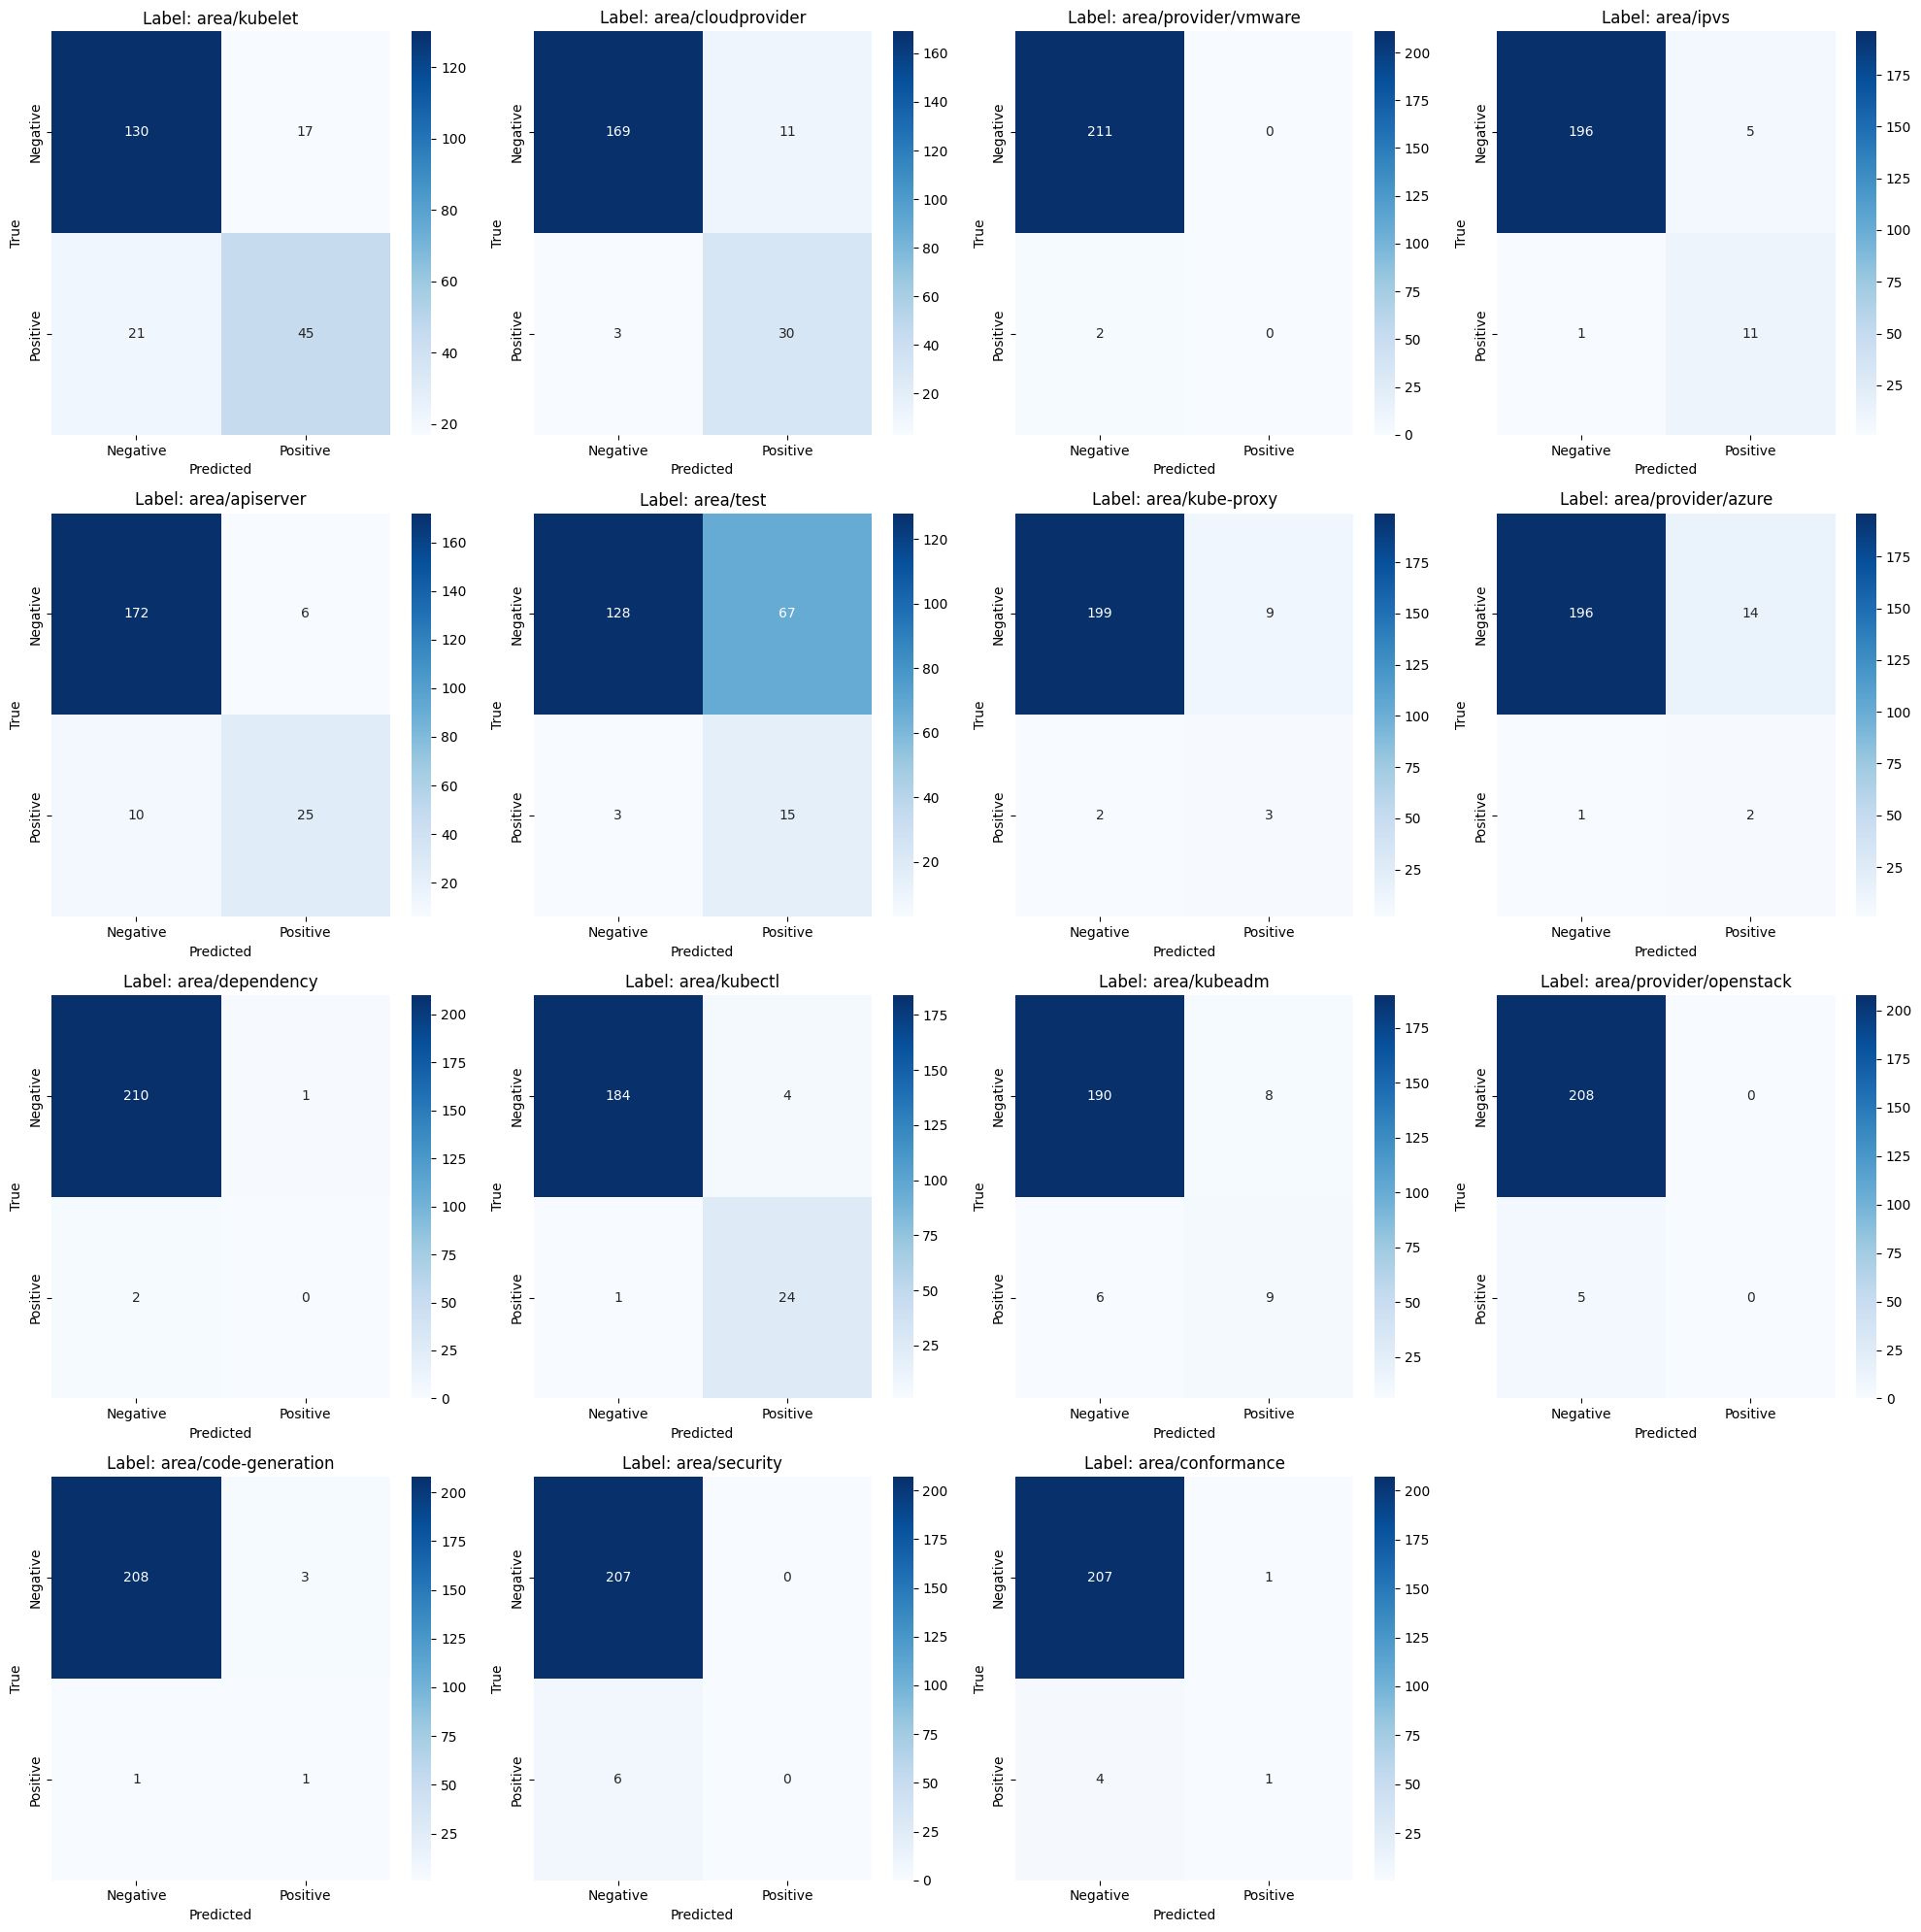

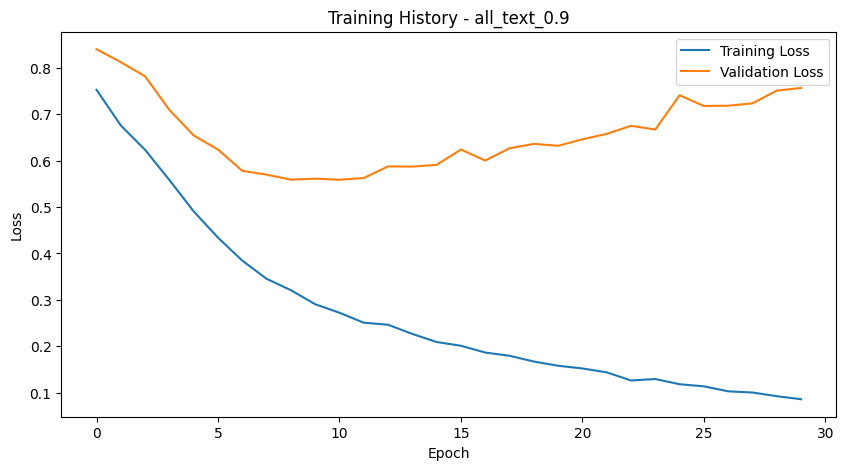

In [2]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/bug-data-comments-no-changed-files/Bug Data with comments without changed files.csv",
                        help='Path to the data file (JSON or CSV format)')
    parser.add_argument('--text_column', type=str, default='all_text_0.9',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=30, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', default=True,
                        help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Feature selection parameters
    parser.add_argument('--feature_selection', action='store_true', default=True,
                        help='Enable ML-based hybrid feature selection (mutually exclusive with --manual_labels)')
    parser.add_argument('--filter_k', type=int, default=20, 
                        help='Number of labels to retain after filter stage')
    parser.add_argument('--final_k', type=int, default=15, 
                        help='Final number of labels to select')
    parser.add_argument('--vectorizer', type=str, choices=['count', 'tfidf'], default='tfidf',
                        help='Vectorizer to use for feature selection')
    parser.add_argument('--wrapper_method', type=str, choices=['rf', 'lr'], default='rf',
                        help='Wrapper method to use for feature selection (rf: Random Forest, lr: Logistic Regression)')
    
    # Manual label selection parameters
    parser.add_argument('--manual_labels', action='store_true', 
                        help='Enable manual label selection instead of ML-based feature selection')
    parser.add_argument('--label_count', type=int, choices=[10, 15], default=10,
                        help='Number of labels to select manually (10 or 15)')
                        
    # CNN model parameters
    parser.add_argument('--filter_sizes', type=int, nargs='+', default=[2,4,6,8,10],
                        help='Filter sizes for CNN layers')
    parser.add_argument('--num_filters', type=int, default=64,
                        help='Number of filters per CNN filter size')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

### Use the with filename labels

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/bug-data-comments-no-changed-files/Bug Data with comments without changed files.csv...
Loading tokenizer...

Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:05<00:00, 215.89it/s]


Token length statistics before filtering:
  Mean: 624.99, Std Dev: 900.26
  Min: 9, Max: 12618
  25th percentile: 184.25
  50th percentile (median): 345.00
  75th percentile: 713.50
Applied 3.0 std dev threshold: (1.00, 3325.77)
Removed 20 samples by std dev filtering (1.59% of data)
Total removed: 20 samples (1.59% of original data)
Remaining: 1238 samples (98.41% of original data)

Token length statistics after all filtering:
  Mean: 543.83, Std Dev: 552.29
  Min: 9, Max: 3193
  25th percentile: 180.00
  50th percentile (median): 338.00
  75th percentile: 677.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1238
Dataset size after basic cleaning: 1238 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Removed 15 samples with no labels
Samples remaining after label filtering: 1223 (98.79% of data)

Ste

Calculating token lengths: 100%|██████████| 1100/1100 [00:03<00:00, 278.67it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 3124
Mean token length: 538.37
Median token length: 324.00
Encoding labels...
Label density: 0.0634
Average labels per sample: 1.20
Feature selection enabled: False
Feature selection disabled
Manual label selection enabled: True
Label count: 15

Performing manual feature selection...
Starting manual feature selection to select 15 labels...
Manual selection: 14 labels
Selected labels: ['area/cloudprovider' 'area/dependency' 'area/kubelet' 'area/apiserver'
 'area/ipvs' 'area/provider/azure' 'area/kubectl' 'area/kube-proxy'
 'area/code-generation' 'area/kubeadm' 'area/test' 'area/provider/gcp'
 'area/security' 'area/conformance']
Training with 14 selected labels: ['area/cloudprovider' 'area/dependency' 'area/kubelet' 'area/apiserver'
 'area/ipvs' 'area/provider/azure' 'area/kubectl' 'area/kube-proxy'
 'area/code-generation' 'area/kubeadm' 'area/test' 'area/provider/gcp'
 'area/security' 'area/conformance']

Removing 22 samples with no la

Training: 100%|██████████| 27/27 [00:50<00:00,  1.86s/it]


Train Loss: 0.8419, Train Accuracy (Exact Match): 0.0162
Val Loss: 0.8334
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.4769
Val Accuracy (Jaccard): 0.1535
Val Precision: 0.1579, Val Recall: 0.4769, Val F1: 0.2314
Saved new best model to ./results/run_20250529_182736_all_text_0.9/best_model_all_text_0.9.pt

Epoch 2/30


Training: 100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Train Loss: 0.7642, Train Accuracy (Exact Match): 0.0615
Val Loss: 0.8081
Val Accuracy (Exact Match): 0.0139
Val Accuracy (Partial Match): 0.5625
Val Accuracy (Jaccard): 0.2231
Val Precision: 0.2347, Val Recall: 0.5625, Val F1: 0.3167
Saved new best model to ./results/run_20250529_182736_all_text_0.9/best_model_all_text_0.9.pt

Epoch 3/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.7129, Train Accuracy (Exact Match): 0.0766
Val Loss: 0.7791
Val Accuracy (Exact Match): 0.0185
Val Accuracy (Partial Match): 0.5370
Val Accuracy (Jaccard): 0.2240
Val Precision: 0.2345, Val Recall: 0.5370, Val F1: 0.3131

Epoch 4/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.6569, Train Accuracy (Exact Match): 0.1357
Val Loss: 0.7190
Val Accuracy (Exact Match): 0.0556
Val Accuracy (Partial Match): 0.5301
Val Accuracy (Jaccard): 0.2720
Val Precision: 0.2878, Val Recall: 0.5301, Val F1: 0.3551
Saved new best model to ./results/run_20250529_182736_all_text_0.9/best_model_all_text_0.9.pt

Epoch 5/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.5802, Train Accuracy (Exact Match): 0.2019
Val Loss: 0.6530
Val Accuracy (Exact Match): 0.1528
Val Accuracy (Partial Match): 0.6597
Val Accuracy (Jaccard): 0.3908
Val Precision: 0.4024, Val Recall: 0.6597, Val F1: 0.4781
Saved new best model to ./results/run_20250529_182736_all_text_0.9/best_model_all_text_0.9.pt

Epoch 6/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


Train Loss: 0.5174, Train Accuracy (Exact Match): 0.2413
Val Loss: 0.6140
Val Accuracy (Exact Match): 0.1898
Val Accuracy (Partial Match): 0.6435
Val Accuracy (Jaccard): 0.4124
Val Precision: 0.4290, Val Recall: 0.6435, Val F1: 0.4926
Saved new best model to ./results/run_20250529_182736_all_text_0.9/best_model_all_text_0.9.pt

Epoch 7/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.4612, Train Accuracy (Exact Match): 0.3132
Val Loss: 0.5747
Val Accuracy (Exact Match): 0.1574
Val Accuracy (Partial Match): 0.7199
Val Accuracy (Jaccard): 0.4275
Val Precision: 0.4375, Val Recall: 0.7199, Val F1: 0.5244
Saved new best model to ./results/run_20250529_182736_all_text_0.9/best_model_all_text_0.9.pt

Epoch 8/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


Train Loss: 0.4144, Train Accuracy (Exact Match): 0.3155
Val Loss: 0.5367
Val Accuracy (Exact Match): 0.2824
Val Accuracy (Partial Match): 0.7454
Val Accuracy (Jaccard): 0.5096
Val Precision: 0.5266, Val Recall: 0.7454, Val F1: 0.5906
Saved new best model to ./results/run_20250529_182736_all_text_0.9/best_model_all_text_0.9.pt

Epoch 9/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.3740, Train Accuracy (Exact Match): 0.3689
Val Loss: 0.5362
Val Accuracy (Exact Match): 0.2917
Val Accuracy (Partial Match): 0.7500
Val Accuracy (Jaccard): 0.5170
Val Precision: 0.5340, Val Recall: 0.7500, Val F1: 0.5969
Saved new best model to ./results/run_20250529_182736_all_text_0.9/best_model_all_text_0.9.pt

Epoch 10/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


Train Loss: 0.3398, Train Accuracy (Exact Match): 0.3898
Val Loss: 0.5342
Val Accuracy (Exact Match): 0.2824
Val Accuracy (Partial Match): 0.7523
Val Accuracy (Jaccard): 0.5116
Val Precision: 0.5243, Val Recall: 0.7523, Val F1: 0.5931

Epoch 11/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


Train Loss: 0.3237, Train Accuracy (Exact Match): 0.3817
Val Loss: 0.5223
Val Accuracy (Exact Match): 0.4028
Val Accuracy (Partial Match): 0.7407
Val Accuracy (Jaccard): 0.5698
Val Precision: 0.5880, Val Recall: 0.7407, Val F1: 0.6299
Saved new best model to ./results/run_20250529_182736_all_text_0.9/best_model_all_text_0.9.pt

Epoch 12/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


Train Loss: 0.2957, Train Accuracy (Exact Match): 0.4466
Val Loss: 0.5121
Val Accuracy (Exact Match): 0.3194
Val Accuracy (Partial Match): 0.7546
Val Accuracy (Jaccard): 0.5316
Val Precision: 0.5448, Val Recall: 0.7546, Val F1: 0.6079

Epoch 13/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.2821, Train Accuracy (Exact Match): 0.4350
Val Loss: 0.5302
Val Accuracy (Exact Match): 0.2639
Val Accuracy (Partial Match): 0.7500
Val Accuracy (Jaccard): 0.5027
Val Precision: 0.5181, Val Recall: 0.7500, Val F1: 0.5875

Epoch 14/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.2604, Train Accuracy (Exact Match): 0.4571
Val Loss: 0.5260
Val Accuracy (Exact Match): 0.3519
Val Accuracy (Partial Match): 0.7454
Val Accuracy (Jaccard): 0.5436
Val Precision: 0.5586, Val Recall: 0.7454, Val F1: 0.6130

Epoch 15/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.2450, Train Accuracy (Exact Match): 0.4791
Val Loss: 0.5222
Val Accuracy (Exact Match): 0.2731
Val Accuracy (Partial Match): 0.7593
Val Accuracy (Jaccard): 0.5162
Val Precision: 0.5316, Val Recall: 0.7593, Val F1: 0.6011

Epoch 16/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


Train Loss: 0.2243, Train Accuracy (Exact Match): 0.4838
Val Loss: 0.5323
Val Accuracy (Exact Match): 0.2963
Val Accuracy (Partial Match): 0.7407
Val Accuracy (Jaccard): 0.5131
Val Precision: 0.5278, Val Recall: 0.7407, Val F1: 0.5909

Epoch 17/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


Train Loss: 0.2177, Train Accuracy (Exact Match): 0.5267
Val Loss: 0.5377
Val Accuracy (Exact Match): 0.2731
Val Accuracy (Partial Match): 0.7569
Val Accuracy (Jaccard): 0.5120
Val Precision: 0.5251, Val Recall: 0.7569, Val F1: 0.5960

Epoch 18/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


Train Loss: 0.1979, Train Accuracy (Exact Match): 0.5186
Val Loss: 0.5561
Val Accuracy (Exact Match): 0.2731
Val Accuracy (Partial Match): 0.7616
Val Accuracy (Jaccard): 0.5177
Val Precision: 0.5309, Val Recall: 0.7616, Val F1: 0.6026

Epoch 19/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.1916, Train Accuracy (Exact Match): 0.5313
Val Loss: 0.5378
Val Accuracy (Exact Match): 0.3148
Val Accuracy (Partial Match): 0.7546
Val Accuracy (Jaccard): 0.5347
Val Precision: 0.5486, Val Recall: 0.7546, Val F1: 0.6119

Epoch 20/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.81s/it]


Train Loss: 0.1786, Train Accuracy (Exact Match): 0.5638
Val Loss: 0.5606
Val Accuracy (Exact Match): 0.3148
Val Accuracy (Partial Match): 0.7384
Val Accuracy (Jaccard): 0.5247
Val Precision: 0.5378, Val Recall: 0.7384, Val F1: 0.5988

Epoch 21/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.1649, Train Accuracy (Exact Match): 0.5800
Val Loss: 0.5843
Val Accuracy (Exact Match): 0.2963
Val Accuracy (Partial Match): 0.7523
Val Accuracy (Jaccard): 0.5239
Val Precision: 0.5370, Val Recall: 0.7523, Val F1: 0.6034

Epoch 22/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.1600, Train Accuracy (Exact Match): 0.5800
Val Loss: 0.5626
Val Accuracy (Exact Match): 0.3796
Val Accuracy (Partial Match): 0.7454
Val Accuracy (Jaccard): 0.5610
Val Precision: 0.5795, Val Recall: 0.7454, Val F1: 0.6258

Epoch 23/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


Train Loss: 0.1490, Train Accuracy (Exact Match): 0.6009
Val Loss: 0.5641
Val Accuracy (Exact Match): 0.3796
Val Accuracy (Partial Match): 0.7431
Val Accuracy (Jaccard): 0.5656
Val Precision: 0.5849, Val Recall: 0.7431, Val F1: 0.6304
Saved new best model to ./results/run_20250529_182736_all_text_0.9/best_model_all_text_0.9.pt

Epoch 24/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.1429, Train Accuracy (Exact Match): 0.6311
Val Loss: 0.5760
Val Accuracy (Exact Match): 0.3565
Val Accuracy (Partial Match): 0.7569
Val Accuracy (Jaccard): 0.5540
Val Precision: 0.5671, Val Recall: 0.7569, Val F1: 0.6242

Epoch 25/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


Train Loss: 0.1365, Train Accuracy (Exact Match): 0.6508
Val Loss: 0.5935
Val Accuracy (Exact Match): 0.3657
Val Accuracy (Partial Match): 0.7361
Val Accuracy (Jaccard): 0.5517
Val Precision: 0.5687, Val Recall: 0.7361, Val F1: 0.6173

Epoch 26/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.1271, Train Accuracy (Exact Match): 0.6531
Val Loss: 0.5800
Val Accuracy (Exact Match): 0.4259
Val Accuracy (Partial Match): 0.7431
Val Accuracy (Jaccard): 0.5880
Val Precision: 0.6057, Val Recall: 0.7431, Val F1: 0.6443
Saved new best model to ./results/run_20250529_182736_all_text_0.9/best_model_all_text_0.9.pt

Epoch 27/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


Train Loss: 0.1182, Train Accuracy (Exact Match): 0.6659
Val Loss: 0.6217
Val Accuracy (Exact Match): 0.3380
Val Accuracy (Partial Match): 0.7338
Val Accuracy (Jaccard): 0.5401
Val Precision: 0.5532, Val Recall: 0.7338, Val F1: 0.6096

Epoch 28/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.1155, Train Accuracy (Exact Match): 0.6937
Val Loss: 0.6261
Val Accuracy (Exact Match): 0.3750
Val Accuracy (Partial Match): 0.7454
Val Accuracy (Jaccard): 0.5664
Val Precision: 0.5833, Val Recall: 0.7454, Val F1: 0.6319

Epoch 29/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.1118, Train Accuracy (Exact Match): 0.6833
Val Loss: 0.6195
Val Accuracy (Exact Match): 0.4352
Val Accuracy (Partial Match): 0.7269
Val Accuracy (Jaccard): 0.5895
Val Precision: 0.6142, Val Recall: 0.7269, Val F1: 0.6427

Epoch 30/30


Training: 100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


Train Loss: 0.1041, Train Accuracy (Exact Match): 0.7111
Val Loss: 0.6756
Val Accuracy (Exact Match): 0.3750
Val Accuracy (Partial Match): 0.7269
Val Accuracy (Jaccard): 0.5586
Val Precision: 0.5756, Val Recall: 0.7269, Val F1: 0.6211

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4259
Partial Match Accuracy: 0.7431
Jaccard Similarity: 0.5880
Precision: 0.6057
Recall: 0.7431
F1 Score: 0.6443

Training completed! Results saved to ./results/run_20250529_182736_all_text_0.9


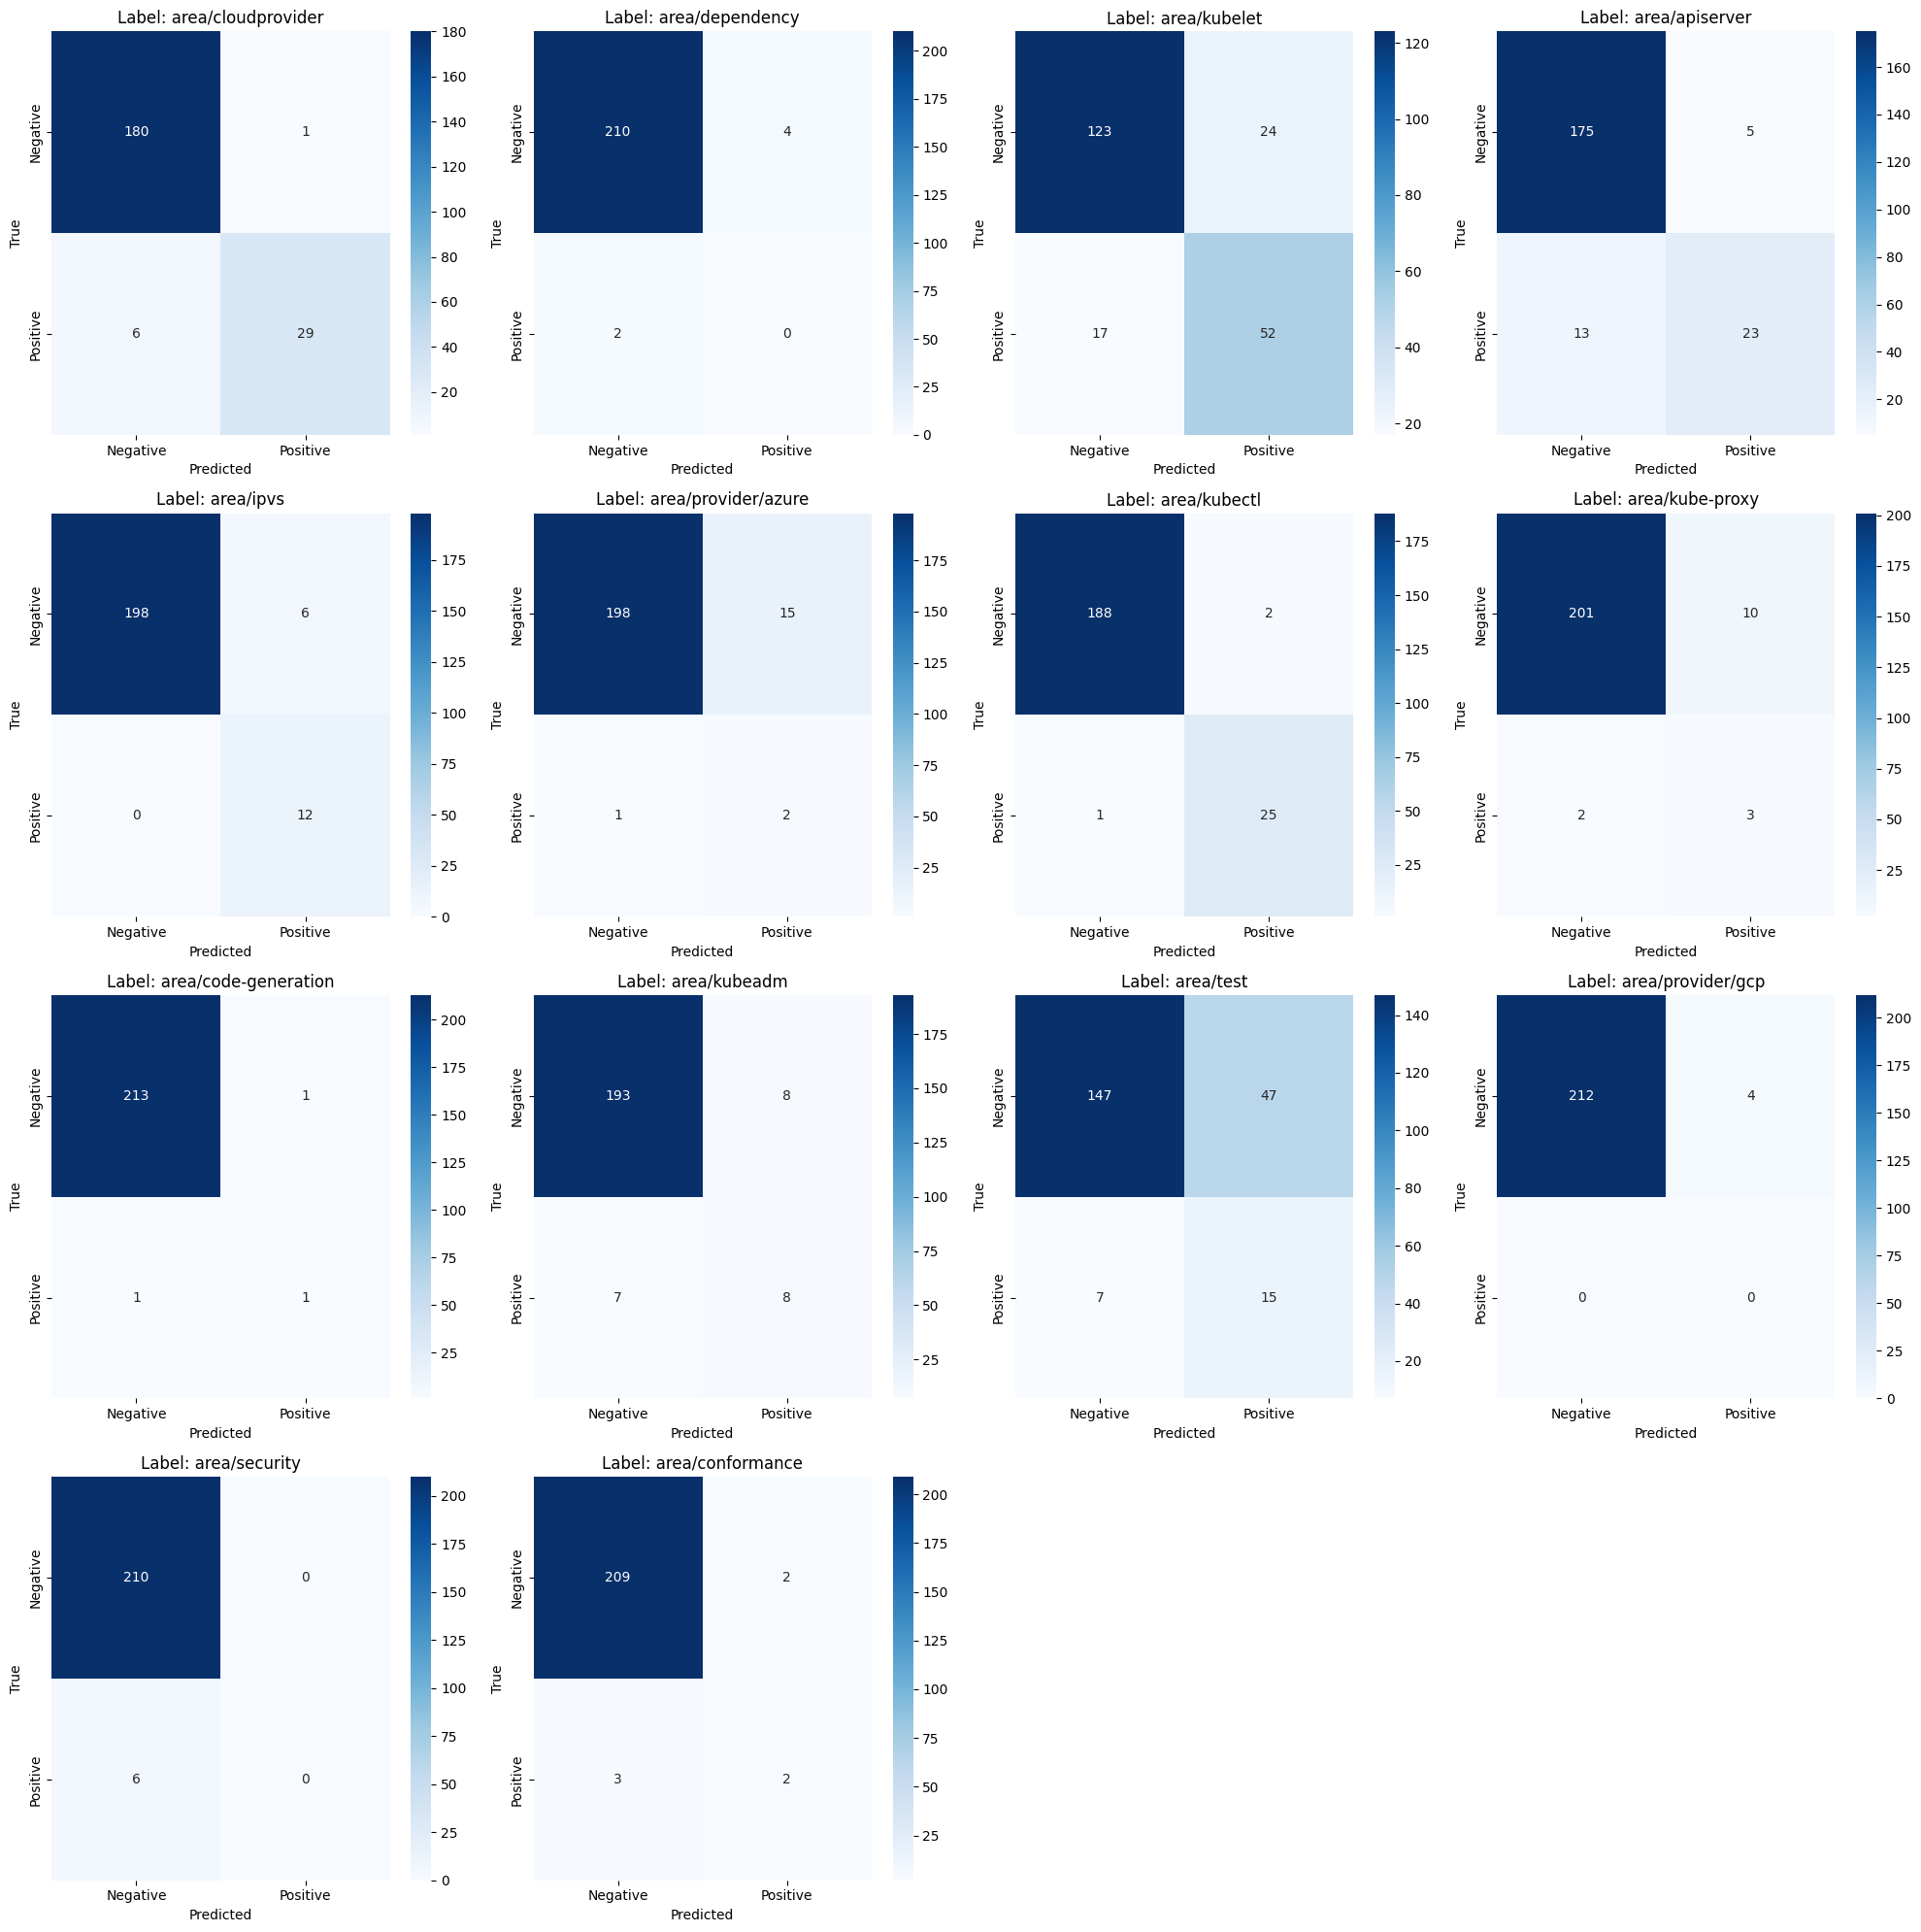

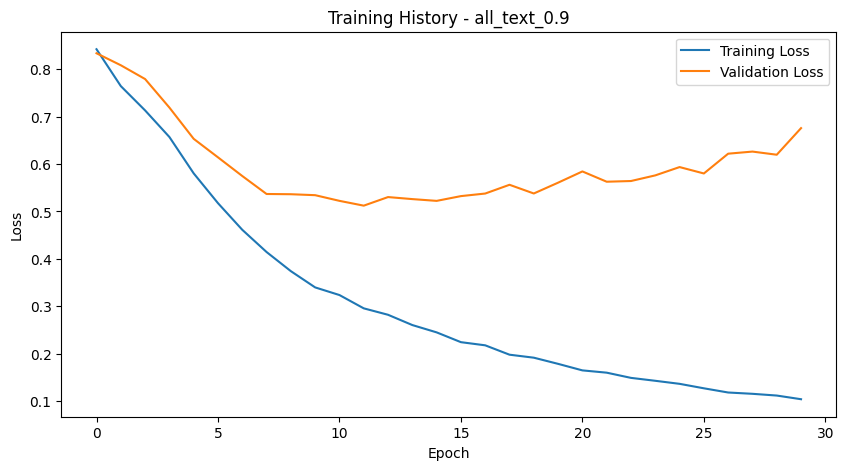

In [3]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/bug-data-comments-no-changed-files/Bug Data with comments without changed files.csv",
                        help='Path to the data file (JSON or CSV format)')
    parser.add_argument('--text_column', type=str, default='all_text_0.9',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=30, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', default=True,
                        help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Feature selection parameters
    parser.add_argument('--feature_selection', action='store_true', 
                        help='Enable ML-based hybrid feature selection (mutually exclusive with --manual_labels)')
    parser.add_argument('--filter_k', type=int, default=20, 
                        help='Number of labels to retain after filter stage')
    parser.add_argument('--final_k', type=int, default=15, 
                        help='Final number of labels to select')
    parser.add_argument('--vectorizer', type=str, choices=['count', 'tfidf'], default='tfidf',
                        help='Vectorizer to use for feature selection')
    parser.add_argument('--wrapper_method', type=str, choices=['rf', 'lr'], default='rf',
                        help='Wrapper method to use for feature selection (rf: Random Forest, lr: Logistic Regression)')
    
    # Manual label selection parameters
    parser.add_argument('--manual_labels', action='store_true', default=True,
                        help='Enable manual label selection instead of ML-based feature selection')
    parser.add_argument('--label_count', type=int, choices=[10, 15], default=15,
                        help='Number of labels to select manually (10 or 15)')
                        
    # CNN model parameters
    parser.add_argument('--filter_sizes', type=int, nargs='+', default=[2,4,6,8,10],
                        help='Filter sizes for CNN layers')
    parser.add_argument('--num_filters', type=int, default=64,
                        help='Number of filters per CNN filter size')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

# 10 Labels

### Wrapper FS

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/bug-data-comments-no-changed-files/Bug Data with comments without changed files.csv...
Loading tokenizer...

Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:05<00:00, 215.02it/s]


Token length statistics before filtering:
  Mean: 624.99, Std Dev: 900.26
  Min: 9, Max: 12618
  25th percentile: 184.25
  50th percentile (median): 345.00
  75th percentile: 713.50
Applied 3.0 std dev threshold: (1.00, 3325.77)
Removed 20 samples by std dev filtering (1.59% of data)
Total removed: 20 samples (1.59% of original data)
Remaining: 1238 samples (98.41% of original data)

Token length statistics after all filtering:
  Mean: 543.83, Std Dev: 552.29
  Min: 9, Max: 3193
  25th percentile: 180.00
  50th percentile (median): 338.00
  75th percentile: 677.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1238
Dataset size after basic cleaning: 1238 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Removed 15 samples with no labels
Samples remaining after label filtering: 1223 (98.79% of data)

Ste

Calculating token lengths: 100%|██████████| 1100/1100 [00:03<00:00, 281.31it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 3124
Mean token length: 538.37
Median token length: 324.00
Encoding labels...
Label density: 0.0634
Average labels per sample: 1.20
Feature selection enabled: True
Filter top-k: 20, Final top-k: 10
Wrapper method: RF

Performing hybrid feature selection...
Using TF-IDF vectorizer for feature selection
Starting hybrid feature selection to select 10 out of 19 labels...
Vectorizing text data...
Applying filter methods...
Filter stage selected 19 labels
Applying wrapper method using RF...


Wrapper evaluation: 100%|██████████| 19/19 [00:05<00:00,  3.37it/s]


Final selection: 10 labels
Selected labels: ['area/kubelet' 'area/cloudprovider' 'area/provider/vmware' 'area/ipvs'
 'area/apiserver' 'area/test' 'area/kube-proxy' 'area/provider/azure'
 'area/dependency' 'area/kubectl']
Training with 10 selected labels: ['area/kubelet' 'area/cloudprovider' 'area/provider/vmware' 'area/ipvs'
 'area/apiserver' 'area/test' 'area/kube-proxy' 'area/provider/azure'
 'area/dependency' 'area/kubectl']

Removing 114 samples with no labels after feature selection (10.36% of data)
Samples remaining after zero-label filtering: 986 (89.64% of data)
Training samples: 788, Validation samples: 198
Loading tokenizer...
Computing class weights for imbalanced labels...
Using larger batch size of 32 for 2 GPUs
Initializing model...
Using CNN with filter sizes [2, 4, 6, 8, 10] and 64 filters per size
Model wrapped in DataParallel
Using weighted BCE loss
Starting training for 30 epochs...

Epoch 1/30


Training: 100%|██████████| 25/25 [00:46<00:00,  1.86s/it]


Train Loss: 0.8855, Train Accuracy (Exact Match): 0.0381
Val Loss: 0.8545
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.5379
Val Accuracy (Jaccard): 0.1894
Val Precision: 0.1935, Val Recall: 0.5379, Val F1: 0.2766
Saved new best model to ./results/run_20250529_185651_all_text_0.9/best_model_all_text_0.9.pt

Epoch 2/30


Training: 100%|██████████| 25/25 [00:43<00:00,  1.74s/it]


Train Loss: 0.8103, Train Accuracy (Exact Match): 0.0431
Val Loss: 0.8137
Val Accuracy (Exact Match): 0.0354
Val Accuracy (Partial Match): 0.5000
Val Accuracy (Jaccard): 0.2336
Val Precision: 0.2483, Val Recall: 0.5000, Val F1: 0.3138
Saved new best model to ./results/run_20250529_185651_all_text_0.9/best_model_all_text_0.9.pt

Epoch 3/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.7398, Train Accuracy (Exact Match): 0.1142
Val Loss: 0.7528
Val Accuracy (Exact Match): 0.0909
Val Accuracy (Partial Match): 0.6641
Val Accuracy (Jaccard): 0.3394
Val Precision: 0.3514, Val Recall: 0.6641, Val F1: 0.4392
Saved new best model to ./results/run_20250529_185651_all_text_0.9/best_model_all_text_0.9.pt

Epoch 4/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.77s/it]


Train Loss: 0.6568, Train Accuracy (Exact Match): 0.2145
Val Loss: 0.6827
Val Accuracy (Exact Match): 0.0758
Val Accuracy (Partial Match): 0.6944
Val Accuracy (Jaccard): 0.3540
Val Precision: 0.3649, Val Recall: 0.6944, Val F1: 0.4608
Saved new best model to ./results/run_20250529_185651_all_text_0.9/best_model_all_text_0.9.pt

Epoch 5/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.76s/it]


Train Loss: 0.5597, Train Accuracy (Exact Match): 0.2513
Val Loss: 0.5918
Val Accuracy (Exact Match): 0.2020
Val Accuracy (Partial Match): 0.6995
Val Accuracy (Jaccard): 0.4449
Val Precision: 0.4554, Val Recall: 0.6995, Val F1: 0.5311
Saved new best model to ./results/run_20250529_185651_all_text_0.9/best_model_all_text_0.9.pt

Epoch 6/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.4904, Train Accuracy (Exact Match): 0.2868
Val Loss: 0.5365
Val Accuracy (Exact Match): 0.2273
Val Accuracy (Partial Match): 0.7828
Val Accuracy (Jaccard): 0.4874
Val Precision: 0.4992, Val Recall: 0.7828, Val F1: 0.5835
Saved new best model to ./results/run_20250529_185651_all_text_0.9/best_model_all_text_0.9.pt

Epoch 7/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.4307, Train Accuracy (Exact Match): 0.3604
Val Loss: 0.4915
Val Accuracy (Exact Match): 0.2929
Val Accuracy (Partial Match): 0.7854
Val Accuracy (Jaccard): 0.5366
Val Precision: 0.5509, Val Recall: 0.7854, Val F1: 0.6221
Saved new best model to ./results/run_20250529_185651_all_text_0.9/best_model_all_text_0.9.pt

Epoch 8/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.79s/it]


Train Loss: 0.3814, Train Accuracy (Exact Match): 0.3604
Val Loss: 0.4663
Val Accuracy (Exact Match): 0.2727
Val Accuracy (Partial Match): 0.8081
Val Accuracy (Jaccard): 0.5295
Val Precision: 0.5412, Val Recall: 0.8081, Val F1: 0.6229
Saved new best model to ./results/run_20250529_185651_all_text_0.9/best_model_all_text_0.9.pt

Epoch 9/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.77s/it]


Train Loss: 0.3504, Train Accuracy (Exact Match): 0.3769
Val Loss: 0.4396
Val Accuracy (Exact Match): 0.3333
Val Accuracy (Partial Match): 0.8005
Val Accuracy (Jaccard): 0.5640
Val Precision: 0.5766, Val Recall: 0.8005, Val F1: 0.6456
Saved new best model to ./results/run_20250529_185651_all_text_0.9/best_model_all_text_0.9.pt

Epoch 10/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.3237, Train Accuracy (Exact Match): 0.4175
Val Loss: 0.4542
Val Accuracy (Exact Match): 0.2374
Val Accuracy (Partial Match): 0.7904
Val Accuracy (Jaccard): 0.5076
Val Precision: 0.5202, Val Recall: 0.7904, Val F1: 0.6034

Epoch 11/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.77s/it]


Train Loss: 0.3022, Train Accuracy (Exact Match): 0.4340
Val Loss: 0.4561
Val Accuracy (Exact Match): 0.2677
Val Accuracy (Partial Match): 0.8081
Val Accuracy (Jaccard): 0.5257
Val Precision: 0.5349, Val Recall: 0.8081, Val F1: 0.6189

Epoch 12/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.2823, Train Accuracy (Exact Match): 0.4657
Val Loss: 0.4406
Val Accuracy (Exact Match): 0.3535
Val Accuracy (Partial Match): 0.8131
Val Accuracy (Jaccard): 0.5859
Val Precision: 0.5976, Val Recall: 0.8131, Val F1: 0.6658
Saved new best model to ./results/run_20250529_185651_all_text_0.9/best_model_all_text_0.9.pt

Epoch 13/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.2636, Train Accuracy (Exact Match): 0.4619
Val Loss: 0.4412
Val Accuracy (Exact Match): 0.3535
Val Accuracy (Partial Match): 0.8182
Val Accuracy (Jaccard): 0.5859
Val Precision: 0.5976, Val Recall: 0.8182, Val F1: 0.6667
Saved new best model to ./results/run_20250529_185651_all_text_0.9/best_model_all_text_0.9.pt

Epoch 14/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.2501, Train Accuracy (Exact Match): 0.4975
Val Loss: 0.4416
Val Accuracy (Exact Match): 0.3636
Val Accuracy (Partial Match): 0.7980
Val Accuracy (Jaccard): 0.5766
Val Precision: 0.5901, Val Recall: 0.7980, Val F1: 0.6524

Epoch 15/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.77s/it]


Train Loss: 0.2367, Train Accuracy (Exact Match): 0.5102
Val Loss: 0.4506
Val Accuracy (Exact Match): 0.3889
Val Accuracy (Partial Match): 0.7929
Val Accuracy (Jaccard): 0.5854
Val Precision: 0.5985, Val Recall: 0.7929, Val F1: 0.6561

Epoch 16/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.77s/it]


Train Loss: 0.2161, Train Accuracy (Exact Match): 0.5863
Val Loss: 0.4800
Val Accuracy (Exact Match): 0.2980
Val Accuracy (Partial Match): 0.8157
Val Accuracy (Jaccard): 0.5530
Val Precision: 0.5657, Val Recall: 0.8157, Val F1: 0.6423

Epoch 17/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.2007, Train Accuracy (Exact Match): 0.5926
Val Loss: 0.4817
Val Accuracy (Exact Match): 0.2980
Val Accuracy (Partial Match): 0.8005
Val Accuracy (Jaccard): 0.5488
Val Precision: 0.5614, Val Recall: 0.8005, Val F1: 0.6355

Epoch 18/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.77s/it]


Train Loss: 0.1973, Train Accuracy (Exact Match): 0.5799
Val Loss: 0.4942
Val Accuracy (Exact Match): 0.3434
Val Accuracy (Partial Match): 0.8106
Val Accuracy (Jaccard): 0.5732
Val Precision: 0.5859, Val Recall: 0.8106, Val F1: 0.6540

Epoch 19/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.1878, Train Accuracy (Exact Match): 0.6015
Val Loss: 0.4959
Val Accuracy (Exact Match): 0.3535
Val Accuracy (Partial Match): 0.8056
Val Accuracy (Jaccard): 0.5770
Val Precision: 0.5892, Val Recall: 0.8056, Val F1: 0.6552

Epoch 20/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.77s/it]


Train Loss: 0.1738, Train Accuracy (Exact Match): 0.6231
Val Loss: 0.5276
Val Accuracy (Exact Match): 0.2828
Val Accuracy (Partial Match): 0.7904
Val Accuracy (Jaccard): 0.5324
Val Precision: 0.5446, Val Recall: 0.7904, Val F1: 0.6199

Epoch 21/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.79s/it]


Train Loss: 0.1641, Train Accuracy (Exact Match): 0.6409
Val Loss: 0.5099
Val Accuracy (Exact Match): 0.3939
Val Accuracy (Partial Match): 0.8056
Val Accuracy (Jaccard): 0.5955
Val Precision: 0.6077, Val Recall: 0.8056, Val F1: 0.6668
Saved new best model to ./results/run_20250529_185651_all_text_0.9/best_model_all_text_0.9.pt

Epoch 22/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.1544, Train Accuracy (Exact Match): 0.6701
Val Loss: 0.5141
Val Accuracy (Exact Match): 0.3687
Val Accuracy (Partial Match): 0.7904
Val Accuracy (Jaccard): 0.5842
Val Precision: 0.5968, Val Recall: 0.7904, Val F1: 0.6574

Epoch 23/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.1437, Train Accuracy (Exact Match): 0.6637
Val Loss: 0.5355
Val Accuracy (Exact Match): 0.3990
Val Accuracy (Partial Match): 0.7854
Val Accuracy (Jaccard): 0.5926
Val Precision: 0.6052, Val Recall: 0.7854, Val F1: 0.6599

Epoch 24/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.77s/it]


Train Loss: 0.1396, Train Accuracy (Exact Match): 0.7005
Val Loss: 0.5304
Val Accuracy (Exact Match): 0.3788
Val Accuracy (Partial Match): 0.8005
Val Accuracy (Jaccard): 0.5888
Val Precision: 0.6014, Val Recall: 0.8005, Val F1: 0.6620

Epoch 25/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.1273, Train Accuracy (Exact Match): 0.7348
Val Loss: 0.5410
Val Accuracy (Exact Match): 0.3939
Val Accuracy (Partial Match): 0.7854
Val Accuracy (Jaccard): 0.5901
Val Precision: 0.6027, Val Recall: 0.7854, Val F1: 0.6582

Epoch 26/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.1241, Train Accuracy (Exact Match): 0.7259
Val Loss: 0.5483
Val Accuracy (Exact Match): 0.3990
Val Accuracy (Partial Match): 0.7626
Val Accuracy (Jaccard): 0.5850
Val Precision: 0.6052, Val Recall: 0.7626, Val F1: 0.6498

Epoch 27/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.1152, Train Accuracy (Exact Match): 0.7386
Val Loss: 0.5452
Val Accuracy (Exact Match): 0.4141
Val Accuracy (Partial Match): 0.7652
Val Accuracy (Jaccard): 0.5939
Val Precision: 0.6162, Val Recall: 0.7652, Val F1: 0.6569

Epoch 28/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.1147, Train Accuracy (Exact Match): 0.7665
Val Loss: 0.5717
Val Accuracy (Exact Match): 0.4141
Val Accuracy (Partial Match): 0.7980
Val Accuracy (Jaccard): 0.6090
Val Precision: 0.6292, Val Recall: 0.7980, Val F1: 0.6771
Saved new best model to ./results/run_20250529_185651_all_text_0.9/best_model_all_text_0.9.pt

Epoch 29/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.0988, Train Accuracy (Exact Match): 0.7906
Val Loss: 0.5981
Val Accuracy (Exact Match): 0.3990
Val Accuracy (Partial Match): 0.7576
Val Accuracy (Jaccard): 0.5850
Val Precision: 0.6052, Val Recall: 0.7576, Val F1: 0.6490

Epoch 30/30


Training: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Train Loss: 0.0966, Train Accuracy (Exact Match): 0.7906
Val Loss: 0.6130
Val Accuracy (Exact Match): 0.3586
Val Accuracy (Partial Match): 0.7551
Val Accuracy (Jaccard): 0.5648
Val Precision: 0.5825, Val Recall: 0.7551, Val F1: 0.6347

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4141
Partial Match Accuracy: 0.7980
Jaccard Similarity: 0.6090
Precision: 0.6292
Recall: 0.7980
F1 Score: 0.6771

Training completed! Results saved to ./results/run_20250529_185651_all_text_0.9


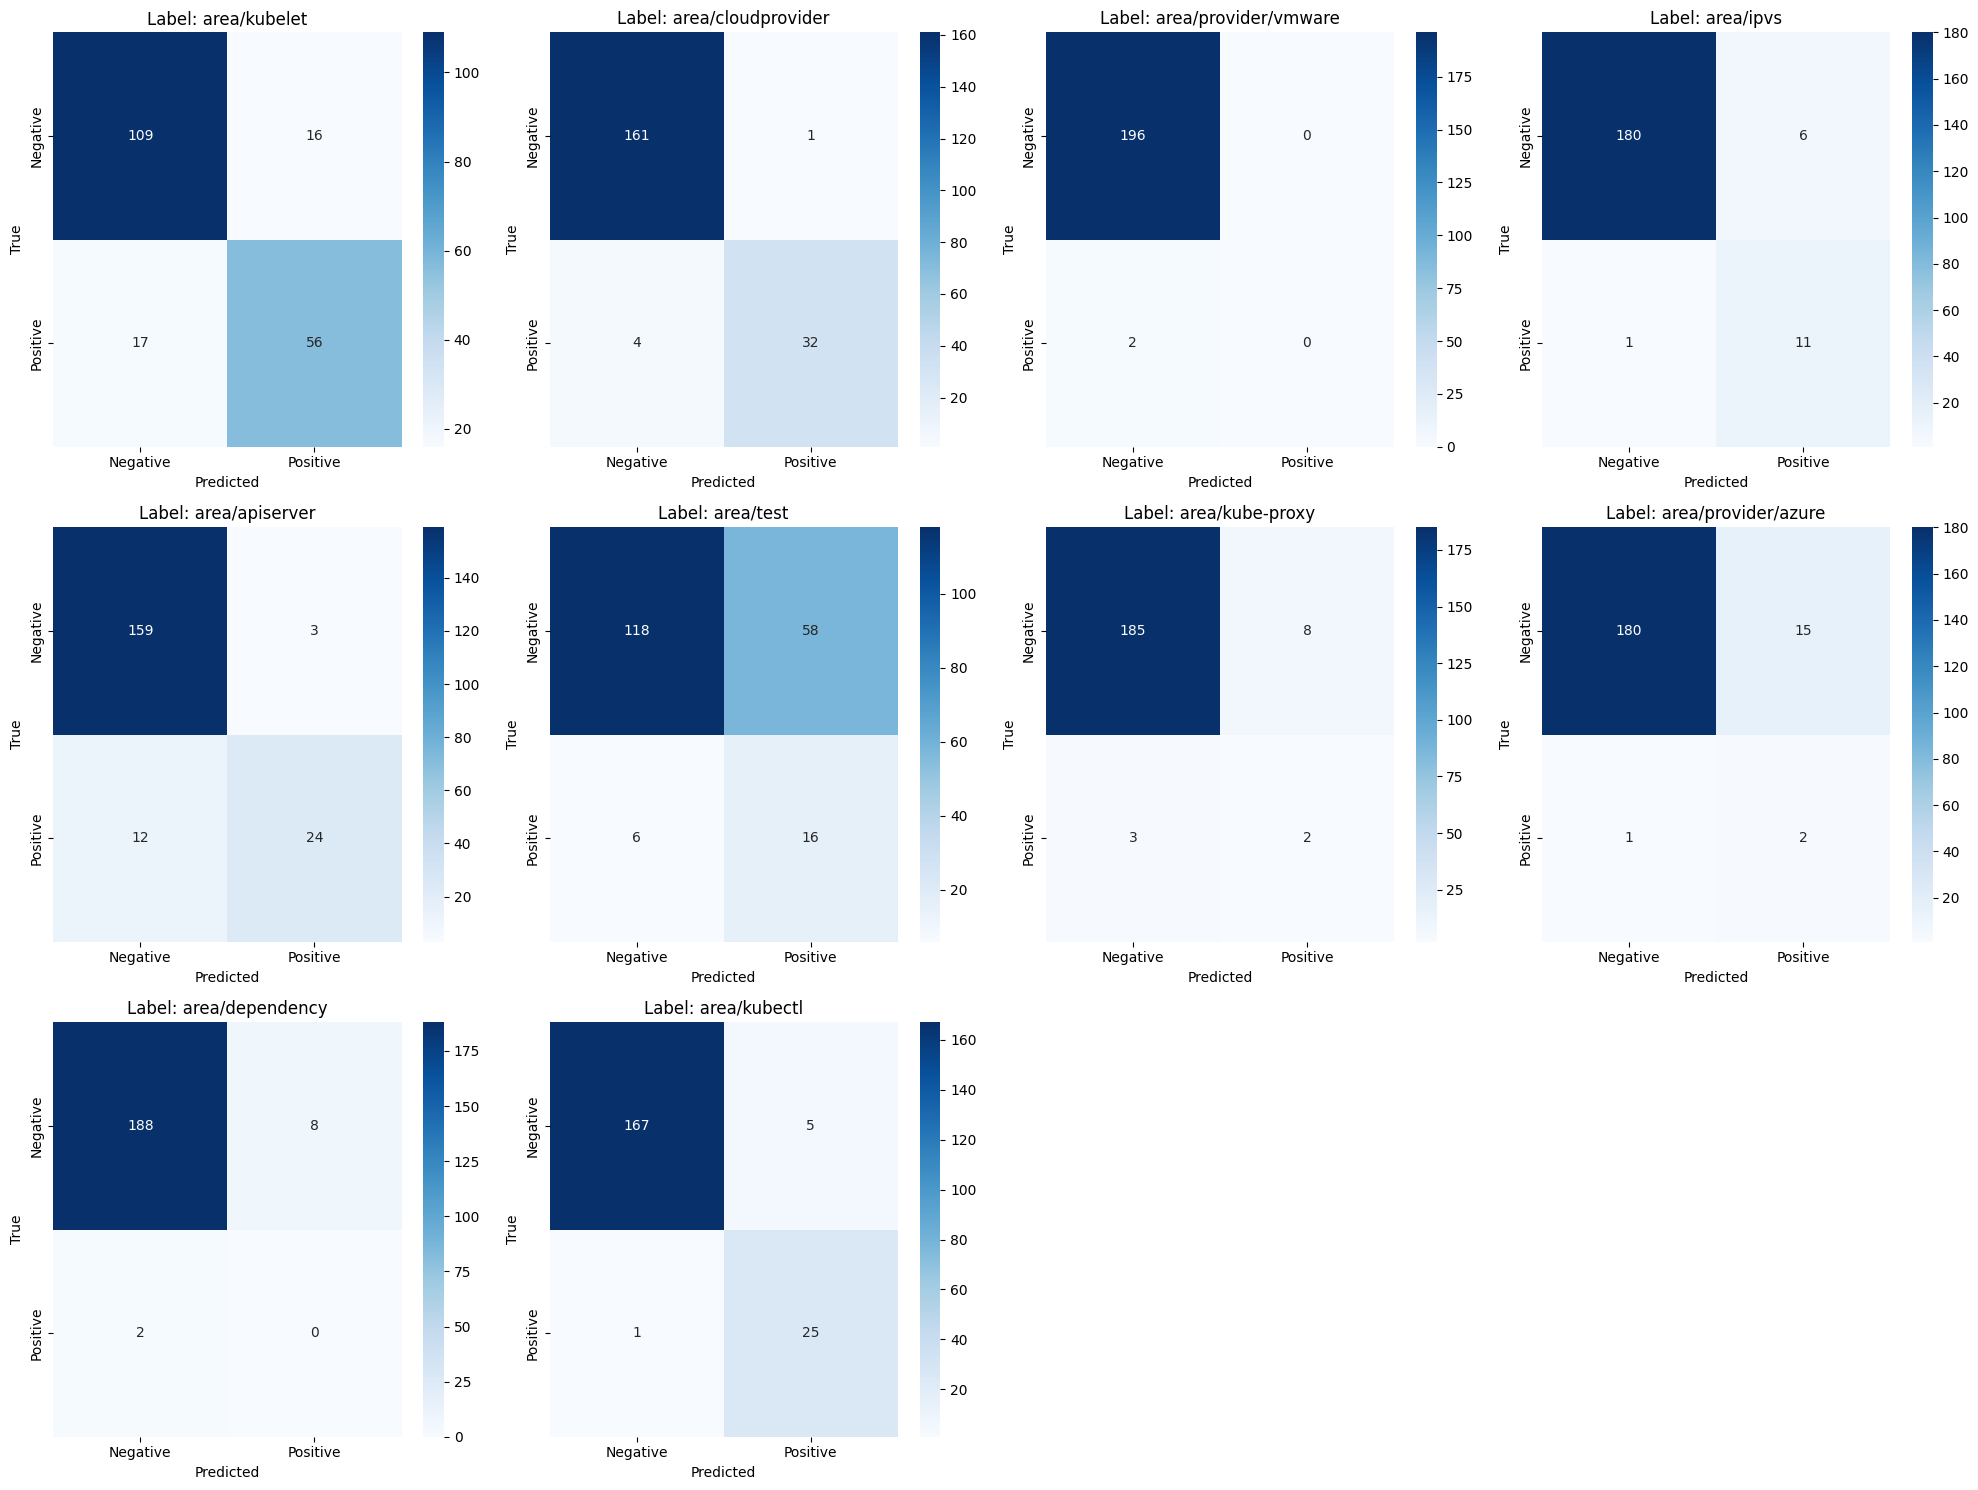

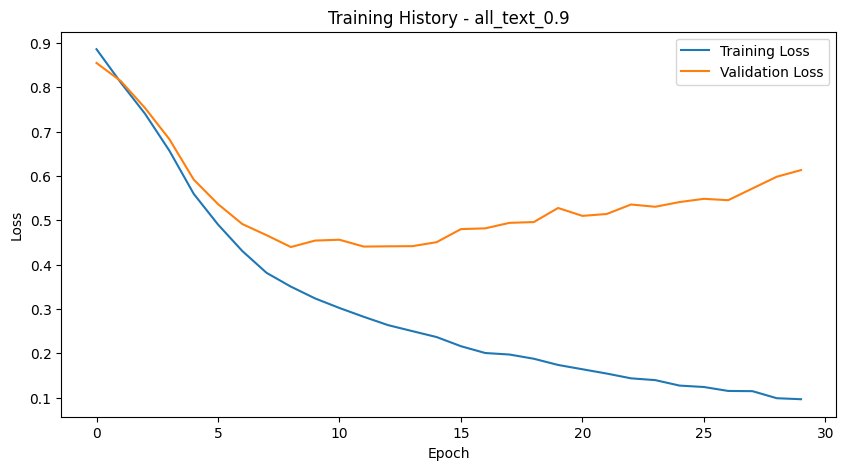

In [4]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/bug-data-comments-no-changed-files/Bug Data with comments without changed files.csv",
                        help='Path to the data file (JSON or CSV format)')
    parser.add_argument('--text_column', type=str, default='all_text_0.9',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=30, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', default=True,
                        help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Feature selection parameters
    parser.add_argument('--feature_selection', action='store_true', default=True,
                        help='Enable ML-based hybrid feature selection (mutually exclusive with --manual_labels)')
    parser.add_argument('--filter_k', type=int, default=20, 
                        help='Number of labels to retain after filter stage')
    parser.add_argument('--final_k', type=int, default=10, 
                        help='Final number of labels to select')
    parser.add_argument('--vectorizer', type=str, choices=['count', 'tfidf'], default='tfidf',
                        help='Vectorizer to use for feature selection')
    parser.add_argument('--wrapper_method', type=str, choices=['rf', 'lr'], default='rf',
                        help='Wrapper method to use for feature selection (rf: Random Forest, lr: Logistic Regression)')
    
    # Manual label selection parameters
    parser.add_argument('--manual_labels', action='store_true', 
                        help='Enable manual label selection instead of ML-based feature selection')
    parser.add_argument('--label_count', type=int, choices=[10, 15], default=10,
                        help='Number of labels to select manually (10 or 15)')
                        
    # CNN model parameters
    parser.add_argument('--filter_sizes', type=int, nargs='+', default=[2,4,6,8,10],
                        help='Filter sizes for CNN layers')
    parser.add_argument('--num_filters', type=int, default=64,
                        help='Number of filters per CNN filter size')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

### Use the with filename labels

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/bug-data-comments-no-changed-files/Bug Data with comments without changed files.csv...
Loading tokenizer...

Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:05<00:00, 210.29it/s]


Token length statistics before filtering:
  Mean: 624.99, Std Dev: 900.26
  Min: 9, Max: 12618
  25th percentile: 184.25
  50th percentile (median): 345.00
  75th percentile: 713.50
Applied 3.0 std dev threshold: (1.00, 3325.77)
Removed 20 samples by std dev filtering (1.59% of data)
Total removed: 20 samples (1.59% of original data)
Remaining: 1238 samples (98.41% of original data)

Token length statistics after all filtering:
  Mean: 543.83, Std Dev: 552.29
  Min: 9, Max: 3193
  25th percentile: 180.00
  50th percentile (median): 338.00
  75th percentile: 677.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1238
Dataset size after basic cleaning: 1238 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Removed 15 samples with no labels
Samples remaining after label filtering: 1223 (98.79% of data)

Ste

Calculating token lengths: 100%|██████████| 1100/1100 [00:03<00:00, 276.00it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 3124
Mean token length: 538.37
Median token length: 324.00
Encoding labels...
Label density: 0.0634
Average labels per sample: 1.20
Feature selection enabled: False
Feature selection disabled
Manual label selection enabled: True
Label count: 10

Performing manual feature selection...
Starting manual feature selection to select 10 labels...
Manual selection: 9 labels
Selected labels: ['area/cloudprovider' 'area/dependency' 'area/kubelet' 'area/apiserver'
 'area/ipvs' 'area/provider/azure' 'area/kubectl' 'area/kube-proxy'
 'area/code-generation']
Training with 9 selected labels: ['area/cloudprovider' 'area/dependency' 'area/kubelet' 'area/apiserver'
 'area/ipvs' 'area/provider/azure' 'area/kubectl' 'area/kube-proxy'
 'area/code-generation']

Removing 272 samples with no labels after feature selection (24.73% of data)
Samples remaining after zero-label filtering: 828 (75.27% of data)
Training samples: 662, Validation samples: 166
Loading

Training: 100%|██████████| 21/21 [00:38<00:00,  1.84s/it]


Train Loss: 0.9835, Train Accuracy (Exact Match): 0.0196
Val Loss: 0.8230
Val Accuracy (Exact Match): 0.0542
Val Accuracy (Partial Match): 0.6145
Val Accuracy (Jaccard): 0.2976
Val Precision: 0.3071, Val Recall: 0.6145, Val F1: 0.3928
Saved new best model to ./results/run_20250529_192539_all_text_0.9/best_model_all_text_0.9.pt

Epoch 2/30


Training: 100%|██████████| 21/21 [00:36<00:00,  1.75s/it]


Train Loss: 0.9049, Train Accuracy (Exact Match): 0.1511
Val Loss: 0.8014
Val Accuracy (Exact Match): 0.1205
Val Accuracy (Partial Match): 0.5392
Val Accuracy (Jaccard): 0.3009
Val Precision: 0.3077, Val Recall: 0.5392, Val F1: 0.3733

Epoch 3/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.79s/it]


Train Loss: 0.8314, Train Accuracy (Exact Match): 0.1858
Val Loss: 0.7613
Val Accuracy (Exact Match): 0.1867
Val Accuracy (Partial Match): 0.6717
Val Accuracy (Jaccard): 0.3963
Val Precision: 0.4091, Val Recall: 0.6717, Val F1: 0.4805
Saved new best model to ./results/run_20250529_192539_all_text_0.9/best_model_all_text_0.9.pt

Epoch 4/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.77s/it]


Train Loss: 0.7567, Train Accuracy (Exact Match): 0.2976
Val Loss: 0.6880
Val Accuracy (Exact Match): 0.2952
Val Accuracy (Partial Match): 0.6386
Val Accuracy (Jaccard): 0.4649
Val Precision: 0.4829, Val Recall: 0.6386, Val F1: 0.5251
Saved new best model to ./results/run_20250529_192539_all_text_0.9/best_model_all_text_0.9.pt

Epoch 5/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.6565, Train Accuracy (Exact Match): 0.3429
Val Loss: 0.6002
Val Accuracy (Exact Match): 0.3494
Val Accuracy (Partial Match): 0.7440
Val Accuracy (Jaccard): 0.5502
Val Precision: 0.5653, Val Recall: 0.7440, Val F1: 0.6185
Saved new best model to ./results/run_20250529_192539_all_text_0.9/best_model_all_text_0.9.pt

Epoch 6/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.77s/it]


Train Loss: 0.5713, Train Accuracy (Exact Match): 0.4486
Val Loss: 0.5620
Val Accuracy (Exact Match): 0.3494
Val Accuracy (Partial Match): 0.7711
Val Accuracy (Jaccard): 0.5582
Val Precision: 0.5683, Val Recall: 0.7711, Val F1: 0.6305
Saved new best model to ./results/run_20250529_192539_all_text_0.9/best_model_all_text_0.9.pt

Epoch 7/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.79s/it]


Train Loss: 0.4961, Train Accuracy (Exact Match): 0.5196
Val Loss: 0.4796
Val Accuracy (Exact Match): 0.3795
Val Accuracy (Partial Match): 0.7590
Val Accuracy (Jaccard): 0.5713
Val Precision: 0.5853, Val Recall: 0.7590, Val F1: 0.6373
Saved new best model to ./results/run_20250529_192539_all_text_0.9/best_model_all_text_0.9.pt

Epoch 8/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.4249, Train Accuracy (Exact Match): 0.5785
Val Loss: 0.4281
Val Accuracy (Exact Match): 0.4217
Val Accuracy (Partial Match): 0.7771
Val Accuracy (Jaccard): 0.5999
Val Precision: 0.6135, Val Recall: 0.7771, Val F1: 0.6618
Saved new best model to ./results/run_20250529_192539_all_text_0.9/best_model_all_text_0.9.pt

Epoch 9/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.3787, Train Accuracy (Exact Match): 0.5559
Val Loss: 0.3969
Val Accuracy (Exact Match): 0.4699
Val Accuracy (Partial Match): 0.8313
Val Accuracy (Jaccard): 0.6431
Val Precision: 0.6506, Val Recall: 0.8313, Val F1: 0.7052
Saved new best model to ./results/run_20250529_192539_all_text_0.9/best_model_all_text_0.9.pt

Epoch 10/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.3429, Train Accuracy (Exact Match): 0.6042
Val Loss: 0.3800
Val Accuracy (Exact Match): 0.5060
Val Accuracy (Partial Match): 0.8163
Val Accuracy (Jaccard): 0.6606
Val Precision: 0.6717, Val Recall: 0.8163, Val F1: 0.7149
Saved new best model to ./results/run_20250529_192539_all_text_0.9/best_model_all_text_0.9.pt

Epoch 11/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.3074, Train Accuracy (Exact Match): 0.6269
Val Loss: 0.3538
Val Accuracy (Exact Match): 0.4940
Val Accuracy (Partial Match): 0.8133
Val Accuracy (Jaccard): 0.6491
Val Precision: 0.6566, Val Recall: 0.8133, Val F1: 0.7042

Epoch 12/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.2873, Train Accuracy (Exact Match): 0.6360
Val Loss: 0.3474
Val Accuracy (Exact Match): 0.5181
Val Accuracy (Partial Match): 0.8343
Val Accuracy (Jaccard): 0.6657
Val Precision: 0.6757, Val Recall: 0.8343, Val F1: 0.7207
Saved new best model to ./results/run_20250529_192539_all_text_0.9/best_model_all_text_0.9.pt

Epoch 13/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.2618, Train Accuracy (Exact Match): 0.6571
Val Loss: 0.3461
Val Accuracy (Exact Match): 0.5000
Val Accuracy (Partial Match): 0.8072
Val Accuracy (Jaccard): 0.6446
Val Precision: 0.6516, Val Recall: 0.8072, Val F1: 0.6976

Epoch 14/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.80s/it]


Train Loss: 0.2415, Train Accuracy (Exact Match): 0.6631
Val Loss: 0.3478
Val Accuracy (Exact Match): 0.5542
Val Accuracy (Partial Match): 0.8012
Val Accuracy (Jaccard): 0.6757
Val Precision: 0.6837, Val Recall: 0.8012, Val F1: 0.7189

Epoch 15/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.79s/it]


Train Loss: 0.2248, Train Accuracy (Exact Match): 0.7054
Val Loss: 0.3423
Val Accuracy (Exact Match): 0.5663
Val Accuracy (Partial Match): 0.8253
Val Accuracy (Jaccard): 0.6913
Val Precision: 0.6988, Val Recall: 0.8253, Val F1: 0.7363
Saved new best model to ./results/run_20250529_192539_all_text_0.9/best_model_all_text_0.9.pt

Epoch 16/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.2101, Train Accuracy (Exact Match): 0.7054
Val Loss: 0.3419
Val Accuracy (Exact Match): 0.6024
Val Accuracy (Partial Match): 0.8464
Val Accuracy (Jaccard): 0.7169
Val Precision: 0.7249, Val Recall: 0.8464, Val F1: 0.7598
Saved new best model to ./results/run_20250529_192539_all_text_0.9/best_model_all_text_0.9.pt

Epoch 17/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.2047, Train Accuracy (Exact Match): 0.7251
Val Loss: 0.3430
Val Accuracy (Exact Match): 0.5120
Val Accuracy (Partial Match): 0.8133
Val Accuracy (Jaccard): 0.6586
Val Precision: 0.6667, Val Recall: 0.8133, Val F1: 0.7108

Epoch 18/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.1911, Train Accuracy (Exact Match): 0.6979
Val Loss: 0.3425
Val Accuracy (Exact Match): 0.5964
Val Accuracy (Partial Match): 0.8313
Val Accuracy (Jaccard): 0.7139
Val Precision: 0.7219, Val Recall: 0.8313, Val F1: 0.7550

Epoch 19/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.77s/it]


Train Loss: 0.1647, Train Accuracy (Exact Match): 0.7628
Val Loss: 0.3352
Val Accuracy (Exact Match): 0.6024
Val Accuracy (Partial Match): 0.8343
Val Accuracy (Jaccard): 0.7219
Val Precision: 0.7309, Val Recall: 0.8343, Val F1: 0.7631
Saved new best model to ./results/run_20250529_192539_all_text_0.9/best_model_all_text_0.9.pt

Epoch 20/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.1615, Train Accuracy (Exact Match): 0.7462
Val Loss: 0.3416
Val Accuracy (Exact Match): 0.6084
Val Accuracy (Partial Match): 0.8253
Val Accuracy (Jaccard): 0.7179
Val Precision: 0.7259, Val Recall: 0.8253, Val F1: 0.7560

Epoch 21/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.1453, Train Accuracy (Exact Match): 0.7810
Val Loss: 0.3442
Val Accuracy (Exact Match): 0.6145
Val Accuracy (Partial Match): 0.8313
Val Accuracy (Jaccard): 0.7194
Val Precision: 0.7269, Val Recall: 0.8313, Val F1: 0.7574

Epoch 22/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.77s/it]


Train Loss: 0.1336, Train Accuracy (Exact Match): 0.8066
Val Loss: 0.3458
Val Accuracy (Exact Match): 0.6325
Val Accuracy (Partial Match): 0.8253
Val Accuracy (Jaccard): 0.7249
Val Precision: 0.7319, Val Recall: 0.8253, Val F1: 0.7588

Epoch 23/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.1220, Train Accuracy (Exact Match): 0.8066
Val Loss: 0.3490
Val Accuracy (Exact Match): 0.6024
Val Accuracy (Partial Match): 0.8223
Val Accuracy (Jaccard): 0.7058
Val Precision: 0.7139, Val Recall: 0.8223, Val F1: 0.7448

Epoch 24/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.77s/it]


Train Loss: 0.1158, Train Accuracy (Exact Match): 0.8369
Val Loss: 0.3648
Val Accuracy (Exact Match): 0.6084
Val Accuracy (Partial Match): 0.8193
Val Accuracy (Jaccard): 0.7108
Val Precision: 0.7189, Val Recall: 0.8193, Val F1: 0.7480

Epoch 25/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.1066, Train Accuracy (Exact Match): 0.8278
Val Loss: 0.3615
Val Accuracy (Exact Match): 0.5904
Val Accuracy (Partial Match): 0.8102
Val Accuracy (Jaccard): 0.6998
Val Precision: 0.7088, Val Recall: 0.8102, Val F1: 0.7390

Epoch 26/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.1030, Train Accuracy (Exact Match): 0.8338
Val Loss: 0.3636
Val Accuracy (Exact Match): 0.6325
Val Accuracy (Partial Match): 0.8223
Val Accuracy (Jaccard): 0.7264
Val Precision: 0.7349, Val Recall: 0.8223, Val F1: 0.7604

Epoch 27/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.0961, Train Accuracy (Exact Match): 0.8338
Val Loss: 0.3750
Val Accuracy (Exact Match): 0.6265
Val Accuracy (Partial Match): 0.8012
Val Accuracy (Jaccard): 0.7139
Val Precision: 0.7219, Val Recall: 0.8012, Val F1: 0.7450

Epoch 28/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.0906, Train Accuracy (Exact Match): 0.8505
Val Loss: 0.3700
Val Accuracy (Exact Match): 0.6205
Val Accuracy (Partial Match): 0.8102
Val Accuracy (Jaccard): 0.7189
Val Precision: 0.7279, Val Recall: 0.8102, Val F1: 0.7530

Epoch 29/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.79s/it]


Train Loss: 0.0818, Train Accuracy (Exact Match): 0.8595
Val Loss: 0.3816
Val Accuracy (Exact Match): 0.6386
Val Accuracy (Partial Match): 0.8102
Val Accuracy (Jaccard): 0.7249
Val Precision: 0.7339, Val Recall: 0.8102, Val F1: 0.7560

Epoch 30/30


Training: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]


Train Loss: 0.0807, Train Accuracy (Exact Match): 0.8897
Val Loss: 0.3863
Val Accuracy (Exact Match): 0.6145
Val Accuracy (Partial Match): 0.8102
Val Accuracy (Jaccard): 0.7118
Val Precision: 0.7209, Val Recall: 0.8102, Val F1: 0.7470

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.6024
Partial Match Accuracy: 0.8343
Jaccard Similarity: 0.7219
Precision: 0.7309
Recall: 0.8343
F1 Score: 0.7631

Training completed! Results saved to ./results/run_20250529_192539_all_text_0.9


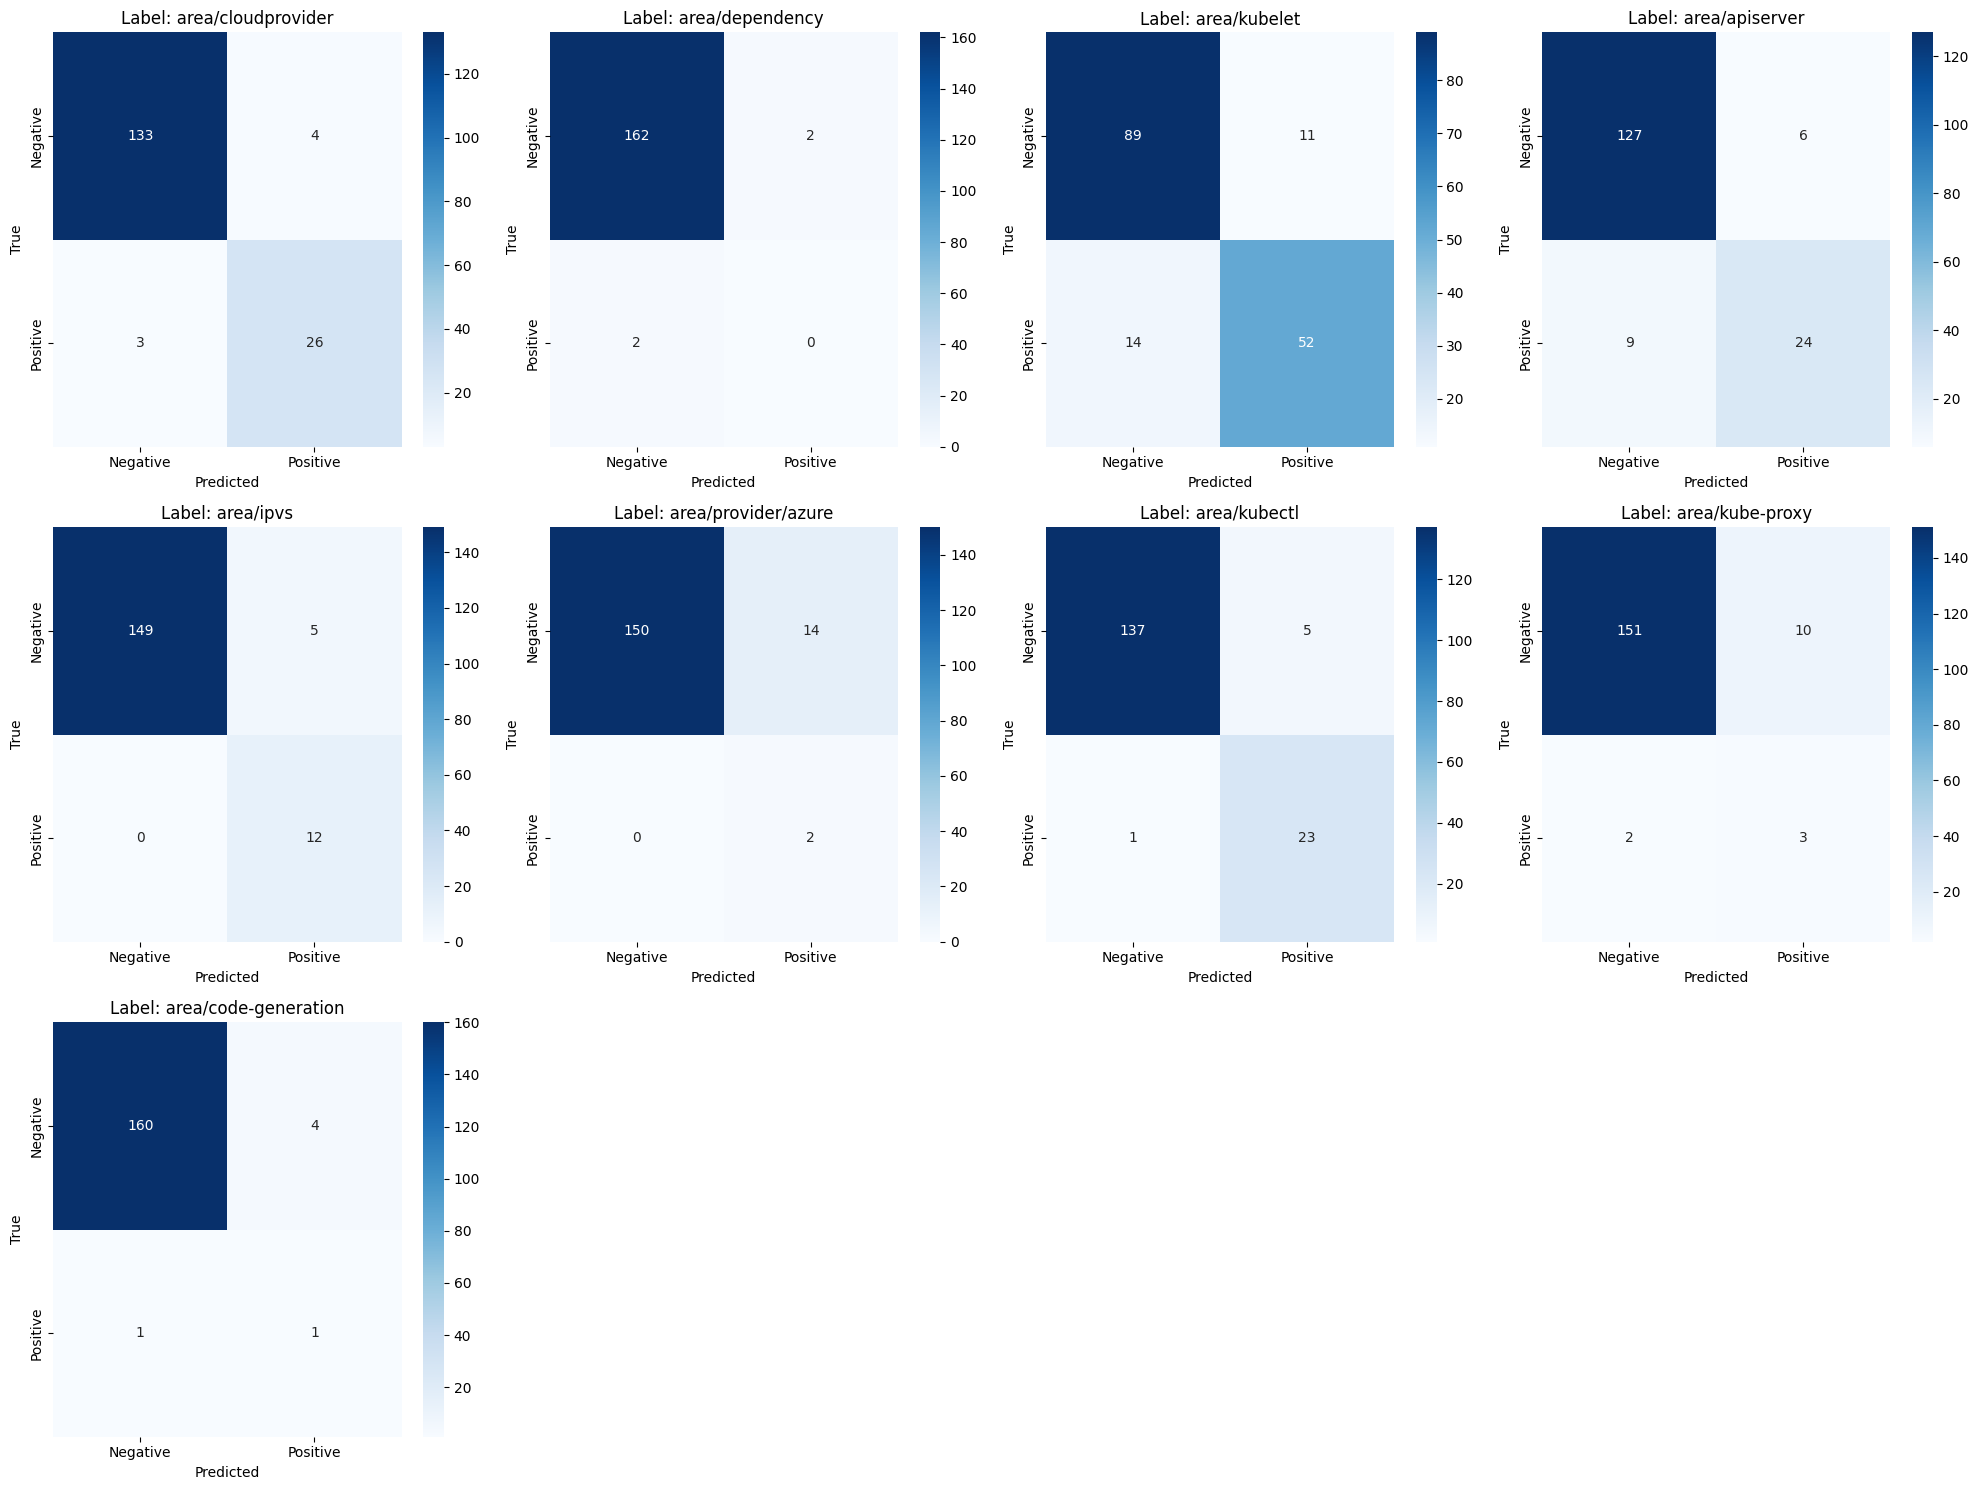

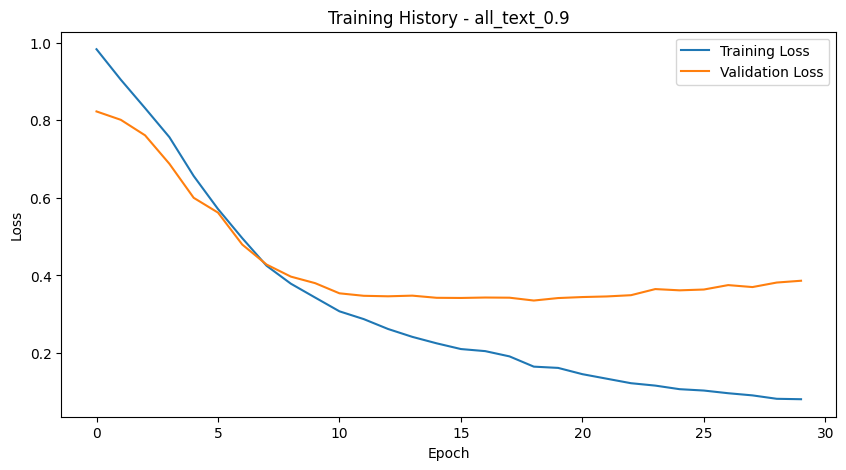

In [5]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/bug-data-comments-no-changed-files/Bug Data with comments without changed files.csv",
                        help='Path to the data file (JSON or CSV format)')
    parser.add_argument('--text_column', type=str, default='all_text_0.9',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=30, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', default=True,
                        help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Feature selection parameters
    parser.add_argument('--feature_selection', action='store_true',
                        help='Enable ML-based hybrid feature selection (mutually exclusive with --manual_labels)')
    parser.add_argument('--filter_k', type=int, default=20, 
                        help='Number of labels to retain after filter stage')
    parser.add_argument('--final_k', type=int, default=10, 
                        help='Final number of labels to select')
    parser.add_argument('--vectorizer', type=str, choices=['count', 'tfidf'], default='tfidf',
                        help='Vectorizer to use for feature selection')
    parser.add_argument('--wrapper_method', type=str, choices=['rf', 'lr'], default='rf',
                        help='Wrapper method to use for feature selection (rf: Random Forest, lr: Logistic Regression)')
    
    # Manual label selection parameters
    parser.add_argument('--manual_labels', action='store_true', default=True,
                        help='Enable manual label selection instead of ML-based feature selection')
    parser.add_argument('--label_count', type=int, choices=[10, 15], default=10,
                        help='Number of labels to select manually (10 or 15)')
                        
    # CNN model parameters
    parser.add_argument('--filter_sizes', type=int, nargs='+', default=[2,4,6,8,10],
                        help='Filter sizes for CNN layers')
    parser.add_argument('--num_filters', type=int, default=64,
                        help='Number of filters per CNN filter size')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)